In [75]:
!git clone --branch modeling --single-branch https://github.com/alinashev/customer_deposit_prediction_assignment


fatal: destination path 'customer_deposit_prediction_assignment' already exists and is not an empty directory.


In [76]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [77]:
import time
import pandas as pd
import numpy as np
import shap

from hyperopt import hp
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [164]:
from customer_deposit_prediction_assignment.enrich.enricher import PolynomialFeatureEnricher

from customer_deposit_prediction_assignment.models.model.decision_tree_model import DecisionTreeModel
from customer_deposit_prediction_assignment.models.model.logistic_regression_model import LogisticRegressionModel
from customer_deposit_prediction_assignment.models.model.knn_model import KNNModel
from customer_deposit_prediction_assignment.models.model.random_forest import RandomForestModel
from customer_deposit_prediction_assignment.models.model.xgboost_model import XGBModel
from customer_deposit_prediction_assignment.models.model.lgbm_model import LGBMModel
from customer_deposit_prediction_assignment.models.utils.model_error_analyzer import ModelErrorAnalyzer
from customer_deposit_prediction_assignment.models.utils.model_сomparison import ModelComparison

from customer_deposit_prediction_assignment.preprocessing.data_processor import DataProcessor
from customer_deposit_prediction_assignment.preprocessing.processor import Processor
from customer_deposit_prediction_assignment.preprocessing.utils.utils import define_numerical_cols

from customer_deposit_prediction_assignment.resampling.smotenc_resampler import SmotencResampler

from customer_deposit_prediction_assignment.tuning.randomized_search_tuner import RandomSearchTuner
from customer_deposit_prediction_assignment.tuning.hyperopt_tuner import HyperoptTuner

from customer_deposit_prediction_assignment.utils.class_dist_visualizer import ClassDistributionVisualizer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [79]:
df_init = pd.read_csv("customer_deposit_prediction_assignment/data/bank-additional-full.csv", sep=';')
df = df_init.copy()

In [80]:
processor = Processor(target_col="y", unnecessary_columns=["duration"], scaling_method="standard")
data_processor = DataProcessor(
    processor=processor,
    apply_outliers_processing=True,
    apply_feature_engineering=True
)

X_train, y_train, X_val, y_val = data_processor.process(df)

In [81]:
display(X_train.head(1)), display(X_val.head(1))

,age,education,contact,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,marital_single,housing_no,housing_yes,loan_no,loan_yes,default_no,default_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
25611,0.89007,3.0,1,11,3,1.174958,-0.376437,-0.114858,-0.648967,-0.324914,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


,age,education,contact,month,day_of_week,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,marital_single,housing_no,housing_yes,loan_no,loan_yes,default_no,default_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
14455,-0.78599,6.0,1,7,2,1.594231,-0.376437,0.8398,0.590675,-0.476655,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


(None, None)

## Resampling

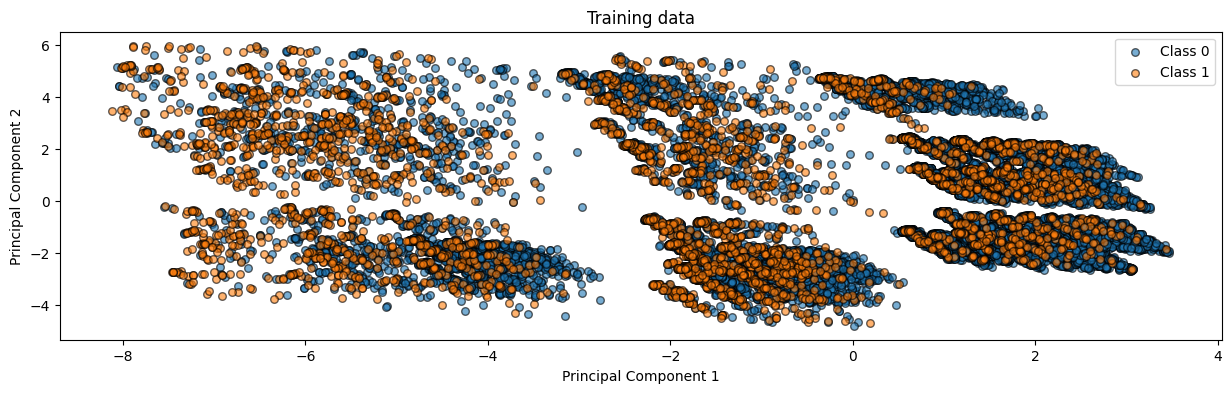

y
0    29238
1     3712
Name: count, dtype: int64


In [82]:
dist_visualizer = ClassDistributionVisualizer(df['y'])
dist_visualizer.plot_data_with_pca(X_train, y_train, title="Training data")

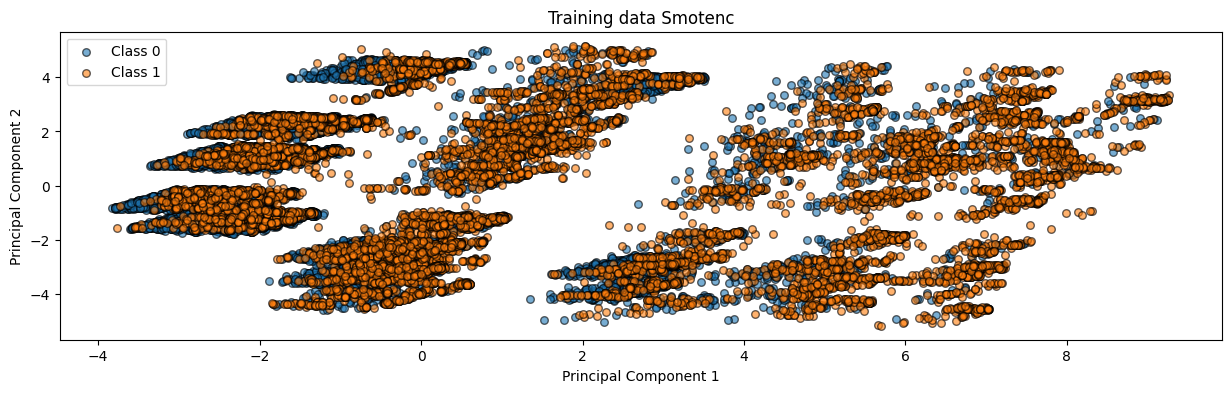

y
0    29238
1    14619
Name: count, dtype: int64


In [83]:
encoded_indices = processor.get_encoded_feature_indices(define_numerical_cols(df))

smotenc_resampler = SmotencResampler(categorical_features=encoded_indices)

X_t_resampled_smotenc, y_t_resampled_smotenc = smotenc_resampler.fit_resample(X_train, y_train)
dist_visualizer.plot_data_with_pca(X_t_resampled_smotenc, y_t_resampled_smotenc, title="Training data Smotenc")

## Modelling

In [84]:
model_comparator = ModelComparison()

def evaluate_model(model, note):
    model_comparator.add_model(model, note)
    model.display_confusion_matrix()
    model.display_roc_auc()
    model_comparator.display_metrics(model.compute_all_metrics())

### LogisticRegressionModel

#### Baseline model

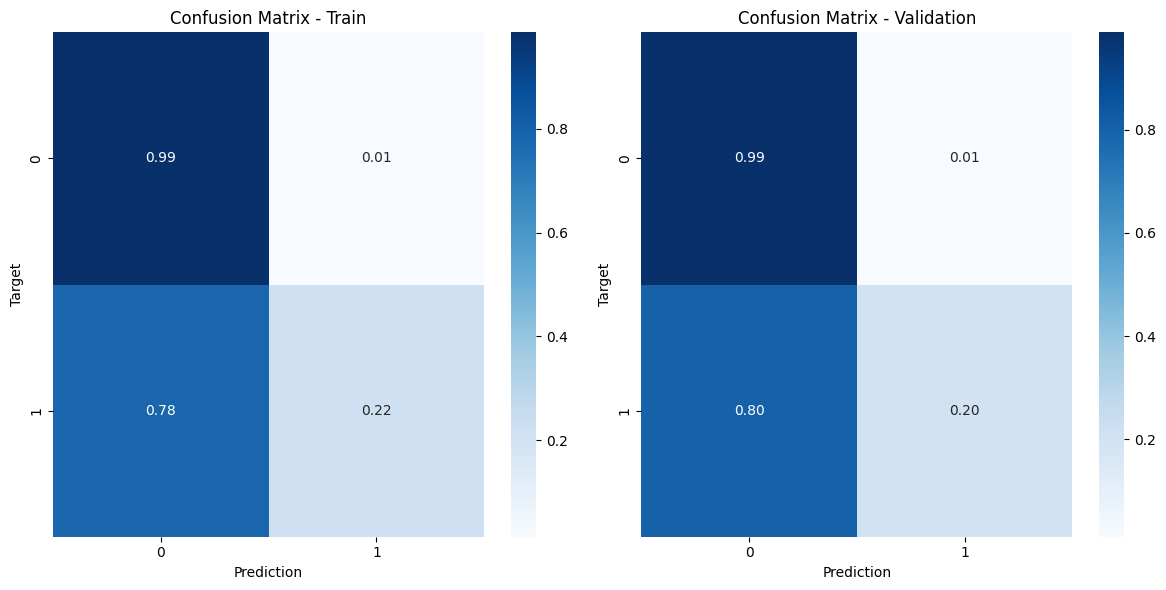

AUROC for Train dataset: 0.7864
AUROC for Validation dataset: 0.7993


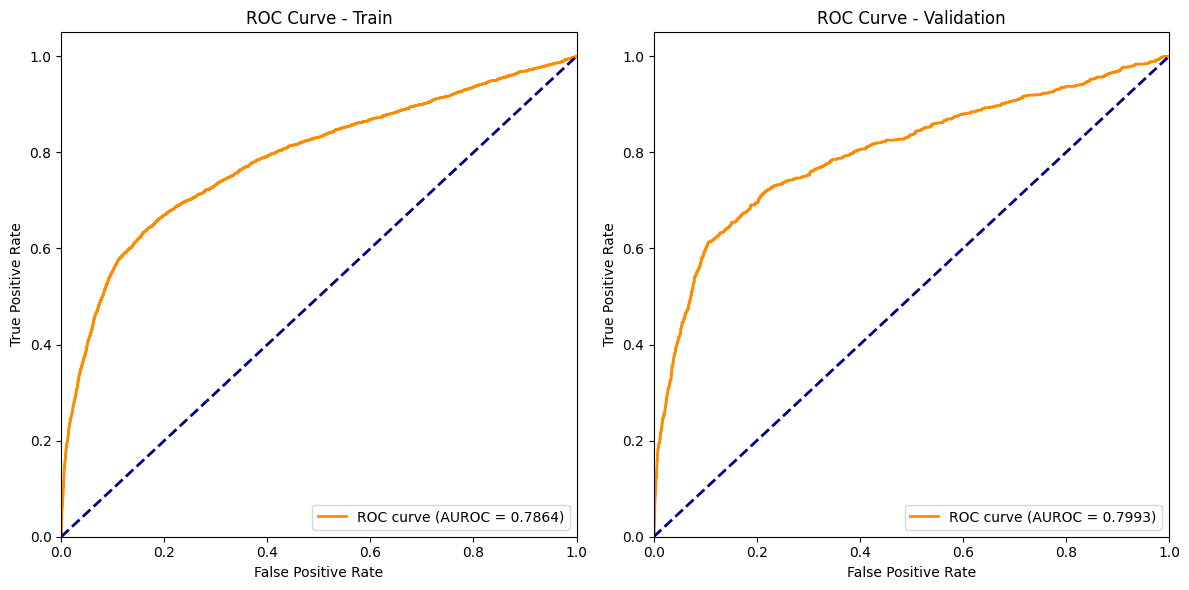

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3273 │           0.3117 │
│ roc_auc  │      0.7864 │           0.7993 │
└──────────┴─────────────┴──────────────────┘

In [85]:
log_model = LogisticRegressionModel(X_train, y_train, X_val, y_val).fit().predict()
evaluate_model(log_model, "Baseline model.")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки (TN): 99% реальних «Ні» правильно передбачено як «Ні».
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав.
- Багато False Negative (FN): модель пропускає 78% (80% на валідаційному наборі) клієнтів.
- Дуже низьке TP (True Positives) – всього 22%: модель майже не передбачає тих, хто справді уклав строковий депозит.
- Бачимо, що результати метрики roc_auc на тренувальній та валідаційній вибірках подібні. Перенавчання не спостерігається.
- Модель не ідеально розрізняє клієнтів, які підпишуть строковий депозит, і тих, які відмовляться.
- F1-score (≈ 0.31) є досить низьким, що вказує на слабку здатність моделі правильно ідентифікувати позитивний клас.
- Модель має дуже високу асиметрію класів: вона переважно передбачає "Ні", а "Так" майже не визначає.
- Основна проблема – модель ігнорує позитивний клас.


In [86]:
model_comparator.update_model_comment(log_model,
                                      "Посередня модель. Слабкий recall для класу 1, F1 = 0.31. Базова модель для порівняння.")

#### LogRegression with polynomial features

Додамо до моделі логістичної регресії поліноміальні ознаки.

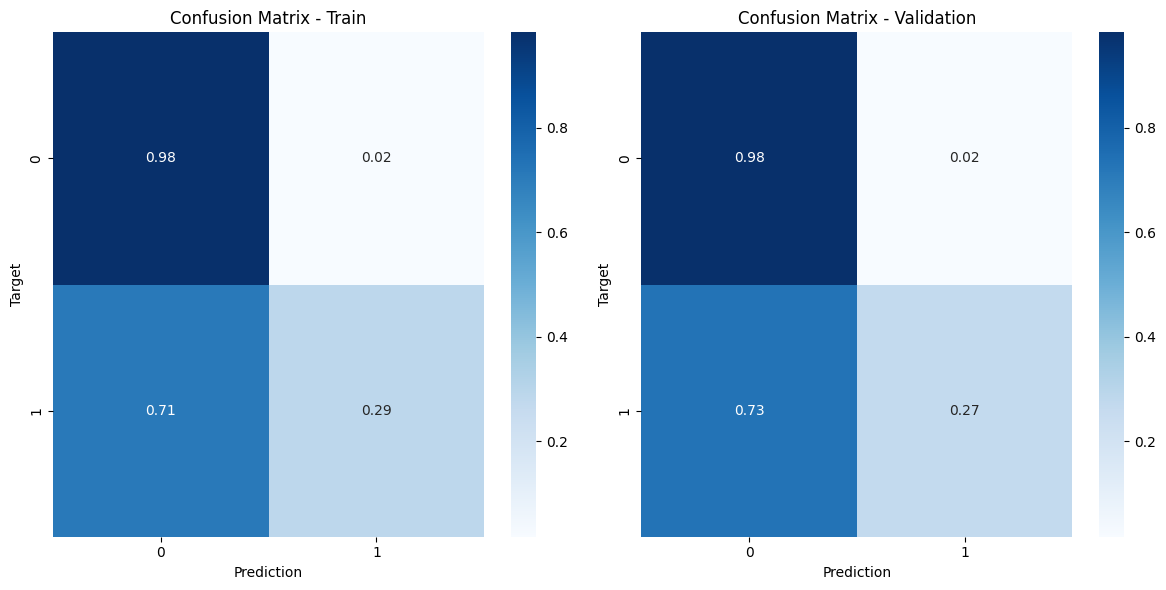

AUROC for Train dataset: 0.8163
AUROC for Validation dataset: 0.7964


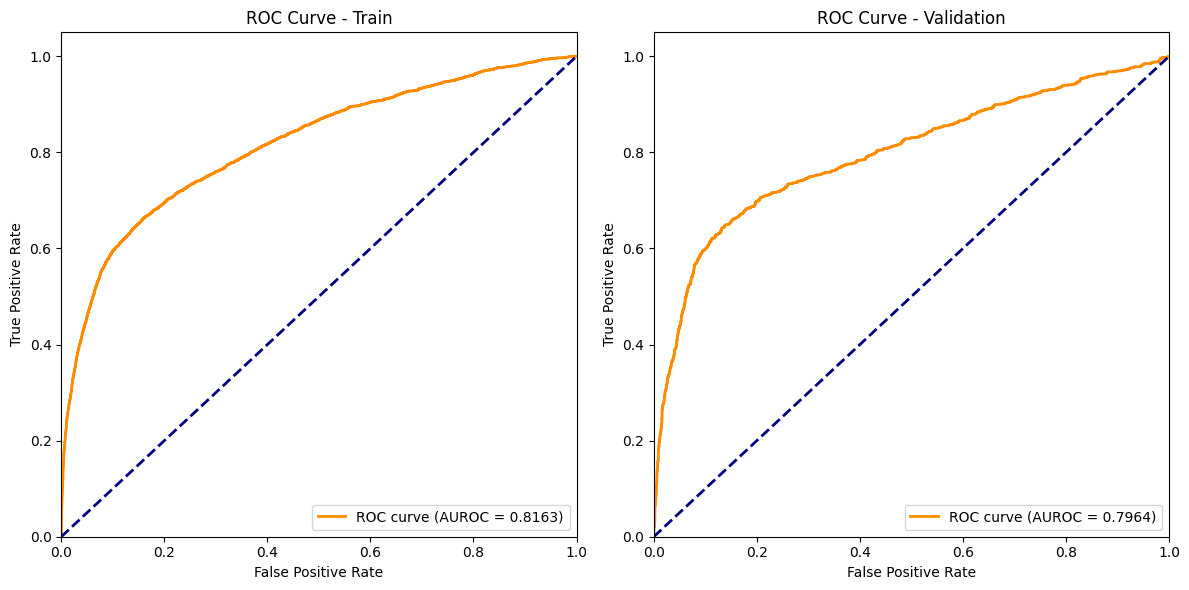

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4028 │           0.3840 │
│ roc_auc  │      0.8163 │           0.7964 │
└──────────┴─────────────┴──────────────────┘

In [87]:
model_log_pol_2 = LogisticRegressionModel(X_train, y_train, X_val, y_val,
                                          enricher=PolynomialFeatureEnricher(degree=2)).fit().predict()
evaluate_model(model_log_pol_2, "Added polynomial features.")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав.
- Багато False Negative (FN): 71% (73% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- Низьке TP (True Positives) – майже 30% - є правильними передбаченнями значення "Так": модель майже не передбачає тих, хто справді уклав строковий депозит, хоча вже показник покращився порівняно з минулою моделлю.
- Значення метрики roc_auc залишається на рівні попередньої моделі (без додавання поліноміальних ознак), що свідчить про схожу здатність моделі розділяти класи.
- Бачимо, що значення метрики на тренувальній вибірці вище за валідаційну, ймовірно присутнє перенавчання.
- F1-score значно покращився відносно попередньої моделі, що означає кращий баланс між Precision та Recall. і що модель краще знаходить клієнтів, які підпишуться.
- Модель виявляє більше позитивних випадків (менше False Negatives), що вже є покращенням.
- Модель все ще надає перевагу класу "Ні".
- Результати метрик показують про можливе наявне невелике перенавчання моделі через додавання поліноміальних ознак.

In [88]:
model_comparator.update_model_comment(model_log_pol_2,
                                      "Посередня модель. Поліноміальні ознаки незначно покращили AUC, але F1 залишився слабким (0.38).")

#### LogRegression with resampling

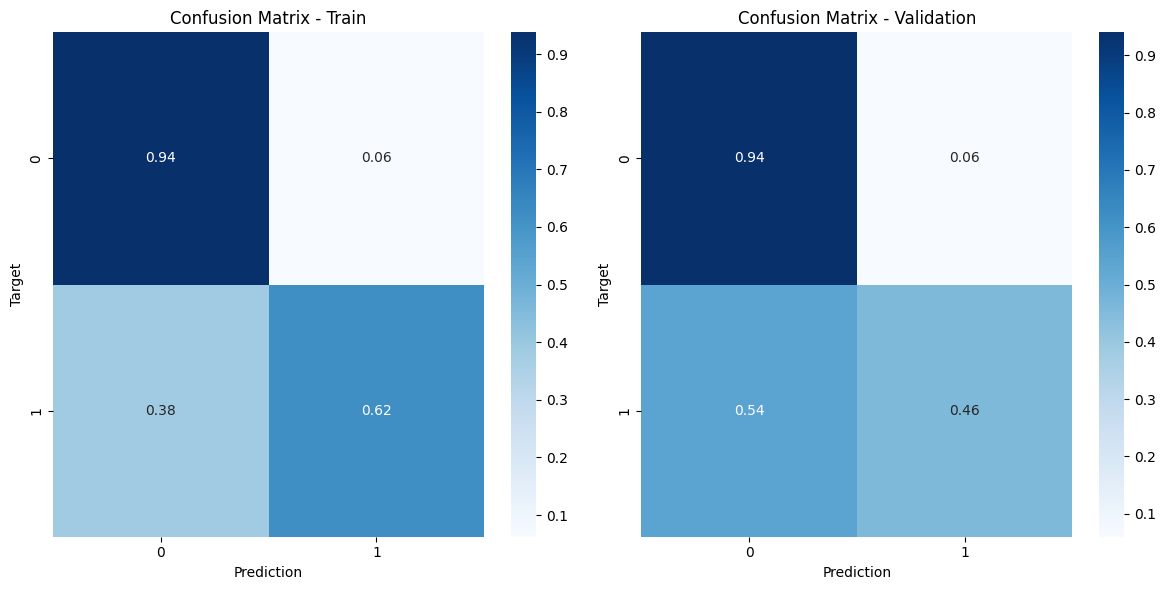

AUROC for Train dataset: 0.8648
AUROC for Validation dataset: 0.7898


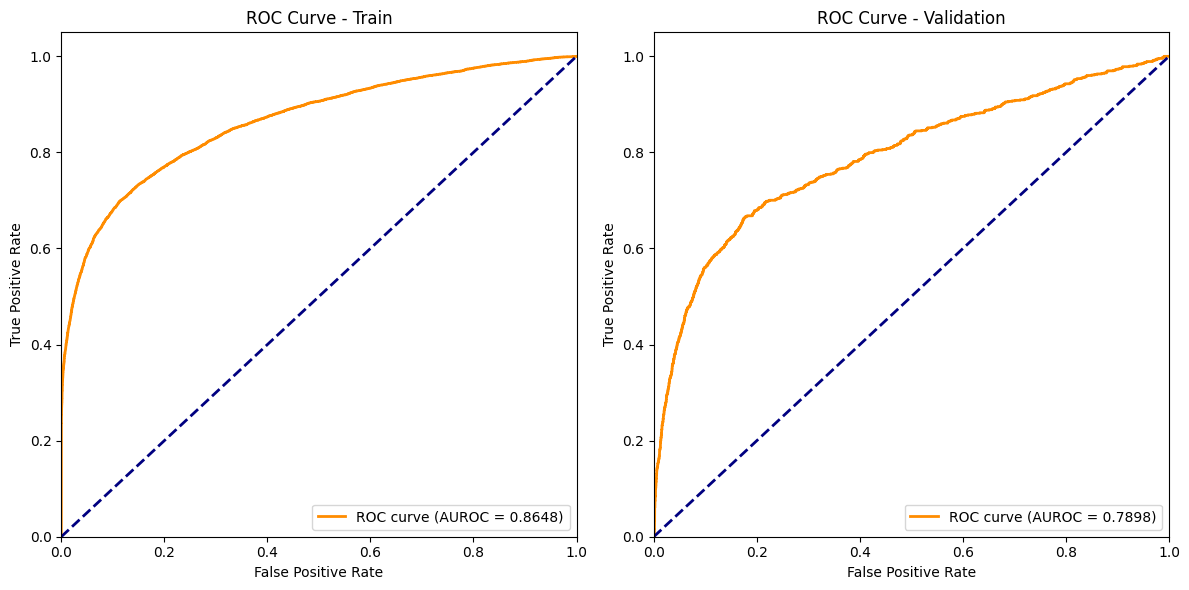

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7104 │           0.4735 │
│ roc_auc  │      0.8648 │           0.7898 │
└──────────┴─────────────┴──────────────────┘

In [89]:
log_model_rs = LogisticRegressionModel(X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, ).fit().predict()
evaluate_model(log_model_rs, "With data resampling.")

**Спостереження**:

- Висока точність (TPR ≈ 86.7%) для класу 0 → модель добре визначає "негативні" приклади.
- Точність для класу 1 значно покращилася (TPR ≈ 58.4% на валідації) → суттєво краще, ніж у попередніх моделях.
- Перенавчання: AUC (Train: 0.8817, Val: 0.7787) → модель добре працює на тренуванні, але якість значно падає на валідації.
- F1-score: 0.79 (Train) → 0.45 (Validation) → високий F1 на тренуванні, але значне падіння на валідації, що вказує на перенавчання.
- Ресемплінг суттєво покращує здатність виявляти позитивний клас, але призводить до перенавчання.
- AUC на валідації (~0.78) навіть нижчий, ніж у моделі з поліноміальними ознаками.

In [90]:
model_comparator.update_model_comment(log_model_rs,
                                      "Посередня модель. Ресемплінг значно покращив TPR для класу 1, але викликав сильне перенавчання (F1 впав з 0.79 до 0.45).")

### kNN

Натренуємо декілька моделей kNN.

#### Модель kNN (k=3, 5, 10)

k=3


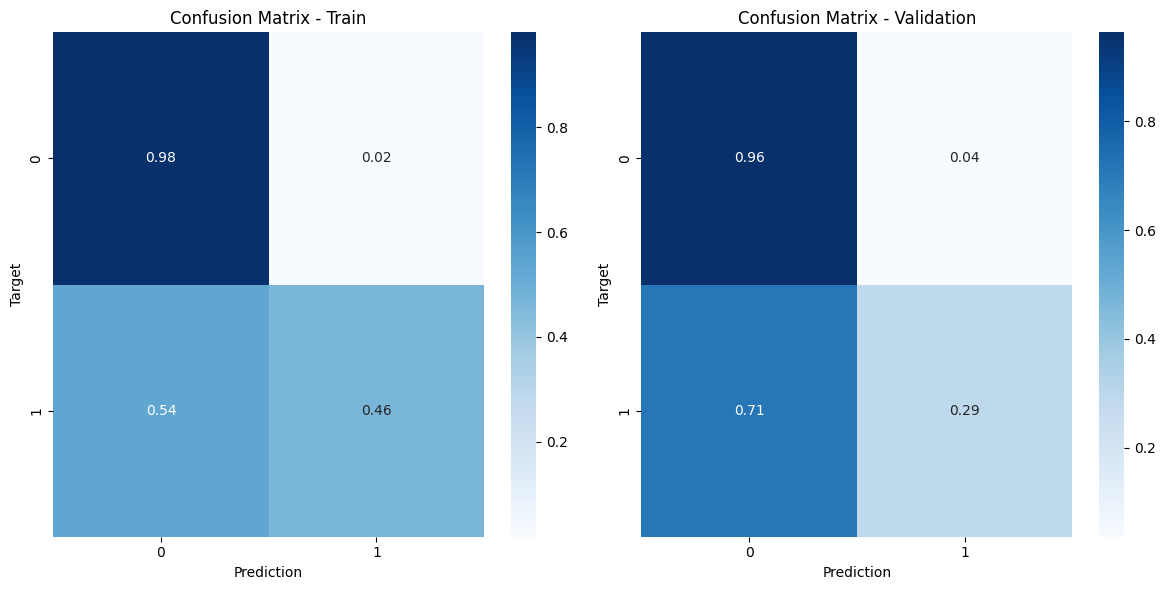

AUROC for Train dataset: 0.9510
AUROC for Validation dataset: 0.7098


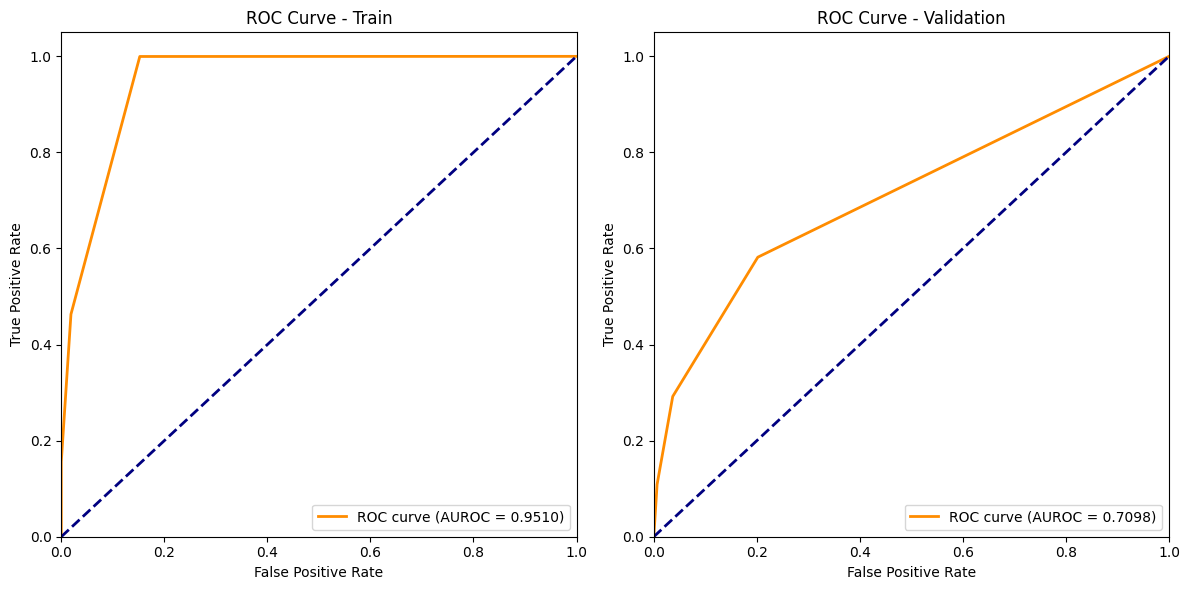

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.5749 │           0.3692 │
│ roc_auc  │      0.9510 │           0.7098 │
└──────────┴─────────────┴──────────────────┘

k=5


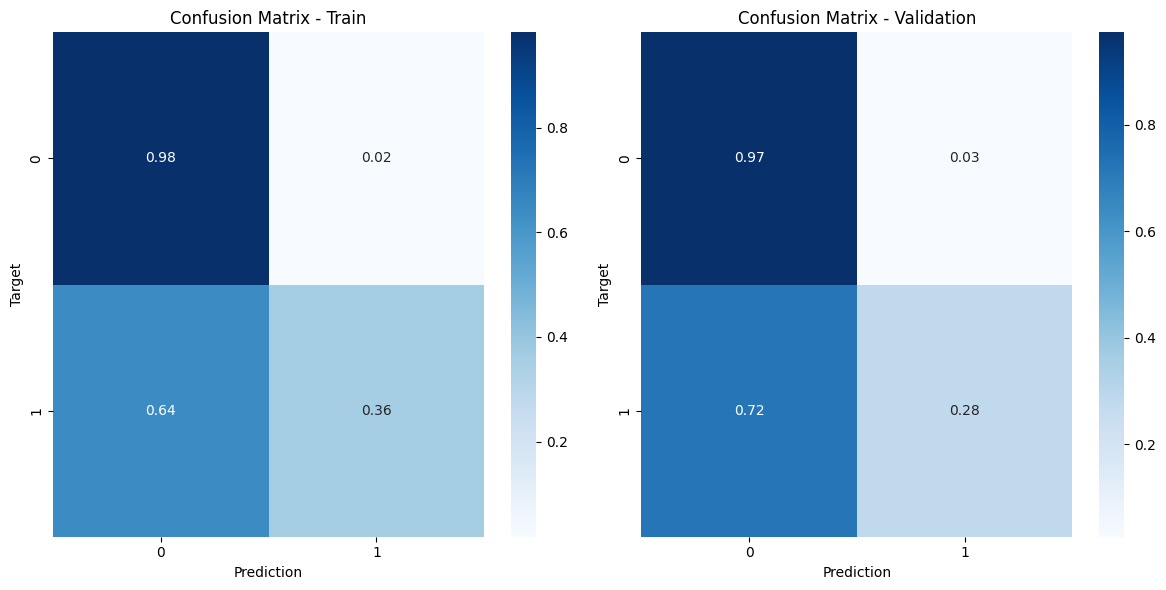

AUROC for Train dataset: 0.9245
AUROC for Validation dataset: 0.7332


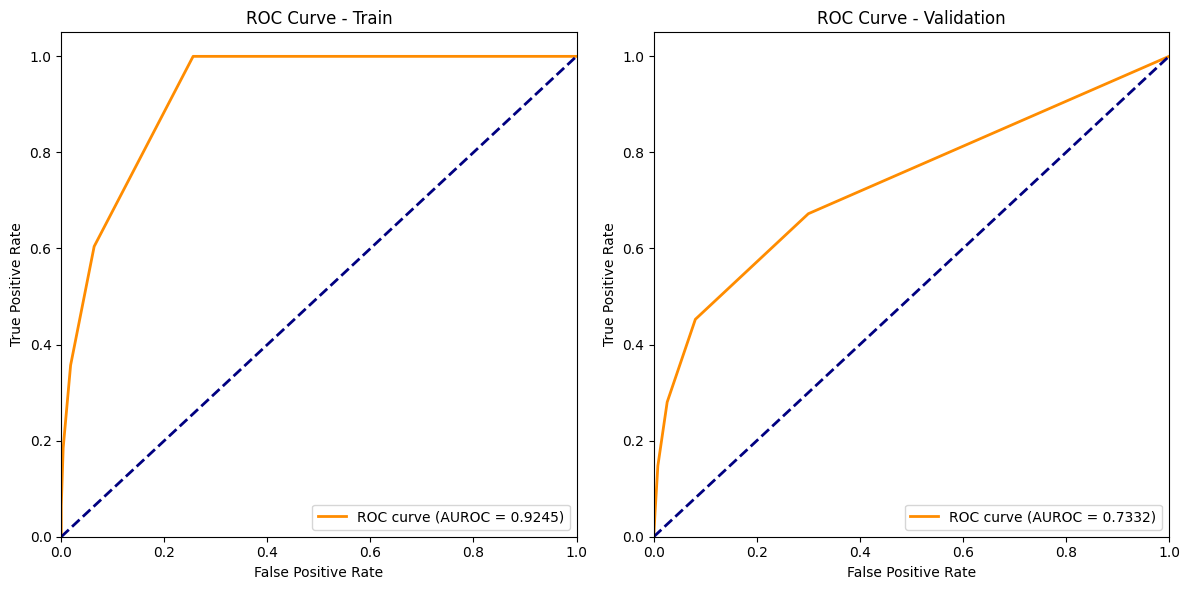

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4761 │           0.3774 │
│ roc_auc  │      0.9245 │           0.7332 │
└──────────┴─────────────┴──────────────────┘

k=10


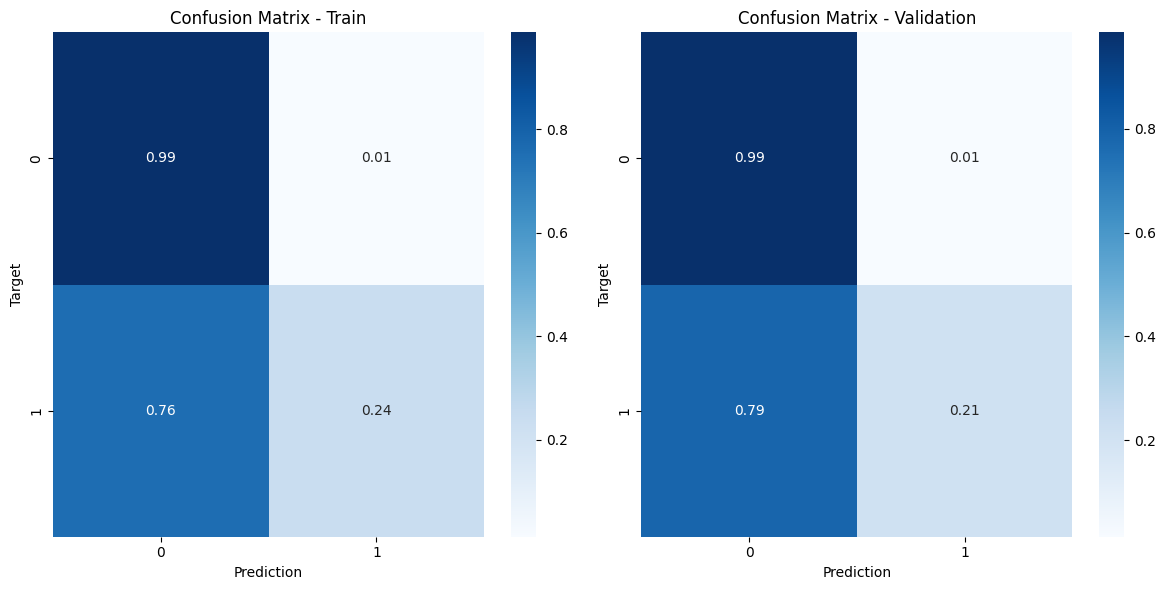

AUROC for Train dataset: 0.8877
AUROC for Validation dataset: 0.7550


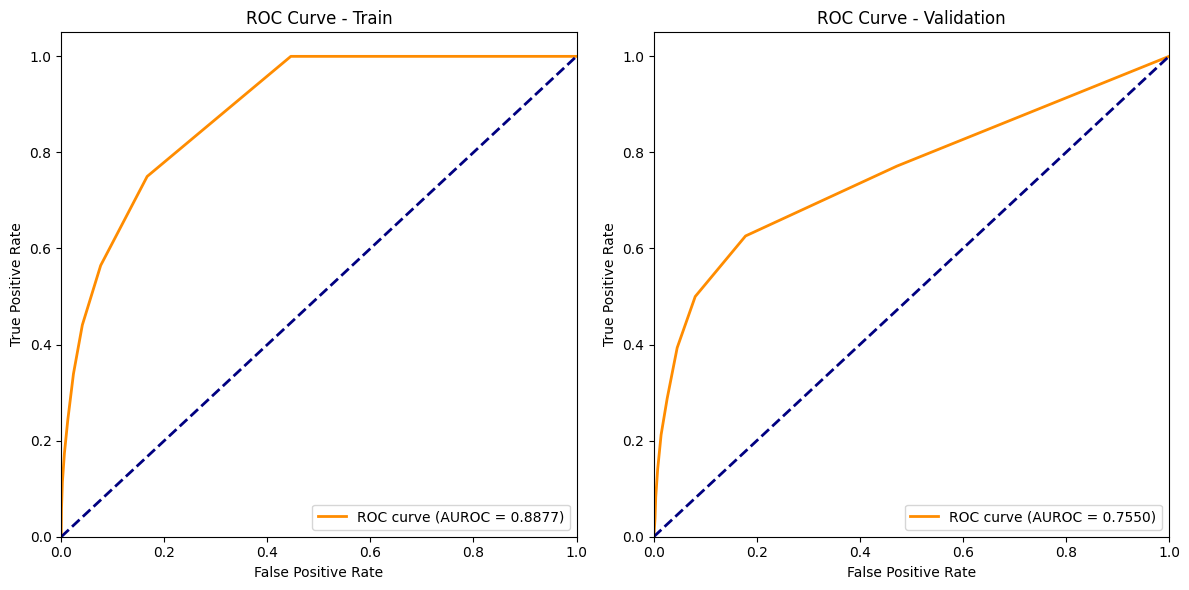

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3612 │           0.3206 │
│ roc_auc  │      0.8877 │           0.7550 │
└──────────┴─────────────┴──────────────────┘

In [91]:
K = [3, 5, 10]
knn_models = {}

for k in K:
    knn_model = KNNModel(X_train, y_train, X_val, y_val, n_neighbors=k).fit().predict()
    print(f"k={k}")
    model_comparator.add_model(knn_model, f"kNN k={k}")
    knn_model.display_confusion_matrix()
    knn_model.display_roc_auc()
    model_comparator.display_metrics(knn_model.compute_all_metrics())

    knn_models[k] = knn_model

**Загальні спостереження про моделі**:

k=3:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (та 4% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків 54% (70% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує майже половину позитивних значень, але на валідації показник падає до 29%, що свідчить про перенавчання.
- Бачимо великий розрив між значеннями метрики для тренувального та валідаційного наборів даних.
- Можемо говорити про явно виражене перенавчання.
- AUROC на тренувальній вибірці дуже високий, а на валідаційній стрімко падає.
-  F1-score значно зменшується, що підтверджує сильне перенавчання.
- Загалом модель на тренувальних даних показує хороший результат, але гірше працює на нових даних.
- Модель дуже добре розпізнає клас "Ні", але гірше справляється з класом "Так"

k=5:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (та 3% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків 63% (72% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 36% позитивних значень, але на валідації показник падає до 28%. Точність передбачення підписки покращилася у порівнянні з k=3, але все ще низька.
- Бачимо, що різниця значень AUROC метрики для тренувального та валідаційного наборів вже знизилась, порівняно з k=3, але все ще маємо достатньо великий розрив. Що говорить нам про перенавчання моделі.
- AUROC на тренувальній вибірці дуже високий, а на валідаційній набагато нижче.
- Різниця між значеннями AUROC зменшилась порівняно з k=3, що вказує на менше перенавчання.
- F1-score став більш стабільним, але твсе ще вказує на перенавчанння.
- Загалом модель на тренувальних даних показує гарний результат, але гірше працює на нових даних.
- Все ще сильний перекіс у передбаченнях – модель краще розпізнає "Ні", ніж "Так".

k=10:

- Модель дуже добре передбачає негативні випадки: 99% реальних «Ні» правильно передбачено як «Ні».
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав. Отже маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 76% (79% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 26% позитивних значень, але на валідації показник падає до 21%. Точність передбачення підписки все ще низька.
- Бачимо, що розрив значень метрики зменшилась у порівнянні з k=5 та k=3. Можемо говорити. що рівень перенавчання зменшилось.
- AUROC на тренувальній вибірці високий, коли на валідаційній набагато нижче.
- Різниця між значеннями AUROC зменшилась порівняно з k=3 та з k=5, що вказує на менше перенавчання.
- F1-score погіршився у порівнянні з k=5, що означає ще більший розрив між передбаченням та реальними даними.
- Загалом модель на тренувальних даних показує гарний результат, але гірше працює на нових даних.
- Все ще сильний перекіс у передбаченнях – модель краще розпізнає "Ні", ніж "Так".

**Загальні спостереження про модельювання за допомогою kNN на оригінальних даних без ресамплінгу**

Проведено моделювання за допомогою kNN з різними значеннями k (3, 5, 10). Можемо зробити наступні висновки:

- Чим менше k (k=3), тим сильніше перенавчання, отже модель ідеально запам’ятовує тренувальні дані, але погано працює на нових даних.
- Чим більше k (k=10), тим менше перенавчання, але все ще погано визначає позитивний клас.
- Модель значно краще передбачає клас "Ні", ніж "Так" → recall для класу "Так" залишається низьким.
- kNN не є ефективним для нашої задачі, особливо в передбаченні позитивного класу.
- Навіть при збільшенні k результати не сильно покращуються, перенавчання зменшується, але результати не наближаються до рівня логістичної регресії.


In [92]:
model_comparator.update_model_comment(knn_models[3],
                                      "Посередня модель. Високий AUC (0.95) на train, але значне падіння (0.71) на валідації. F1 слабкий (0.37). k=3 занадто мале.")
model_comparator.update_model_comment(knn_models[5],
                                      "Посередня модель. AUC впав з 0.92 (train) до 0.73 (val). F1 слабкий (0.38). k=5 трохи покращує ситуацію, але не вирішує проблему.")
model_comparator.update_model_comment(knn_models[10],
                                      "Посередня модель. Менше перенавчання, але слабкий F1 (0.32). AUC зріс до 0.75, але модель все ще погано розпізнає позитивний клас.")

#### Модель kNN з ресамплінгом (k=3, 5, 10)

k=3


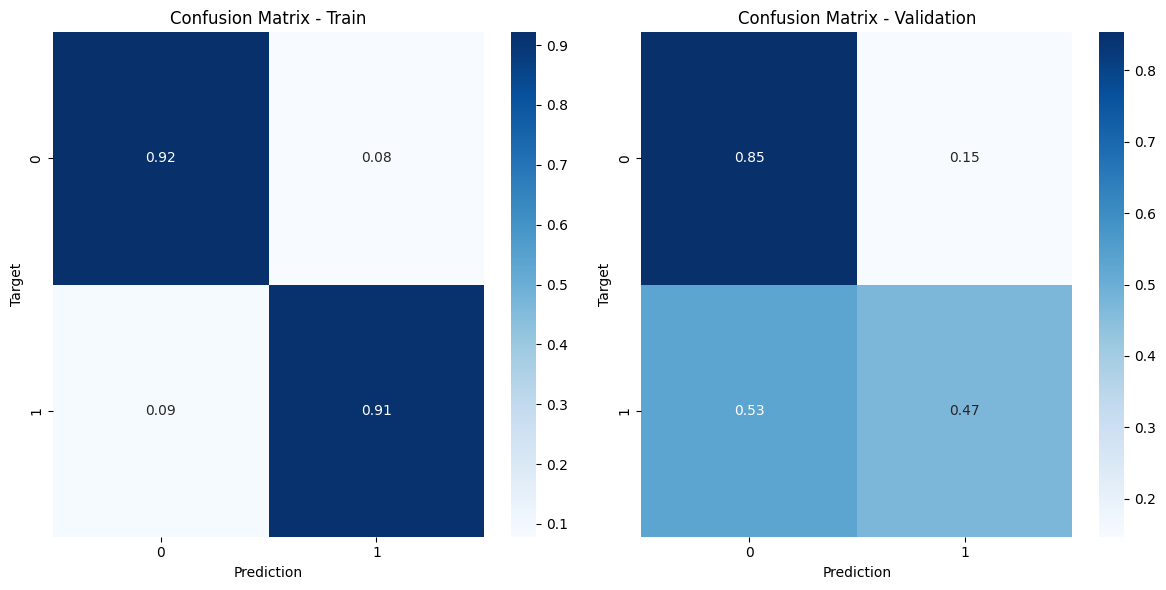

AUROC for Train dataset: 0.9800
AUROC for Validation dataset: 0.7058


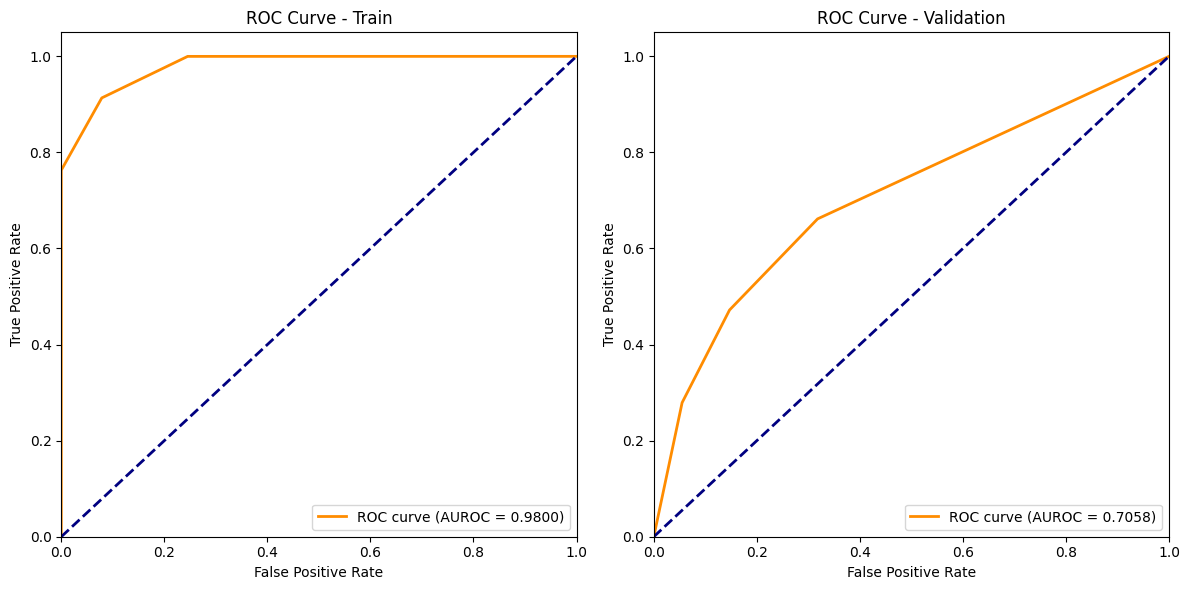

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8823 │           0.3589 │
│ roc_auc  │      0.9800 │           0.7058 │
└──────────┴─────────────┴──────────────────┘

k=5


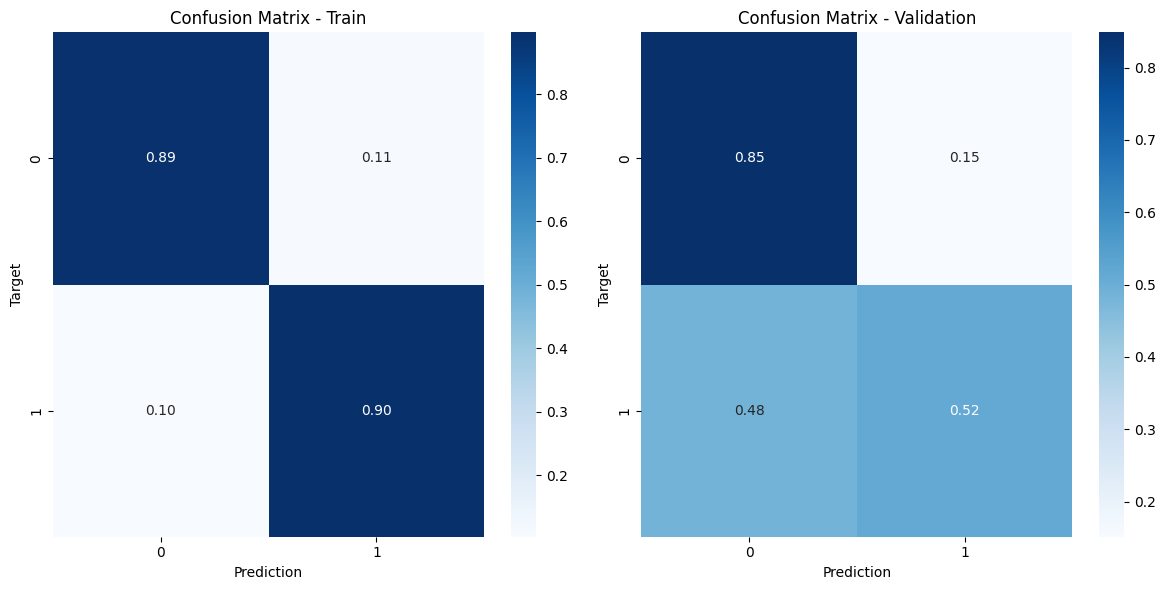

AUROC for Train dataset: 0.9661
AUROC for Validation dataset: 0.7273


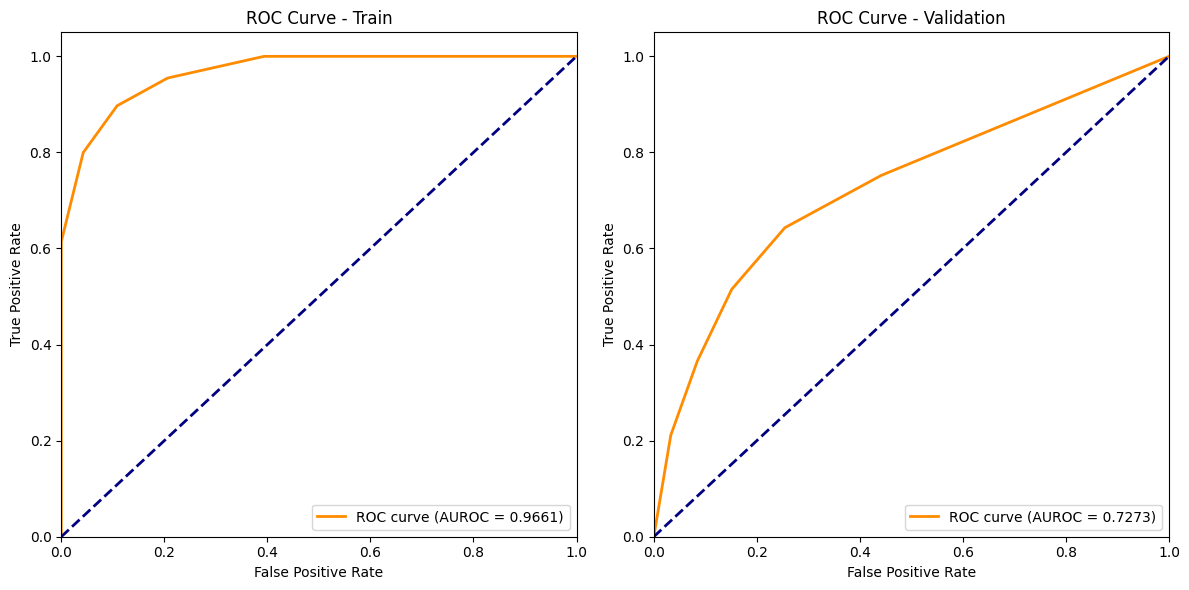

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8488 │           0.3806 │
│ roc_auc  │      0.9661 │           0.7273 │
└──────────┴─────────────┴──────────────────┘

k=10


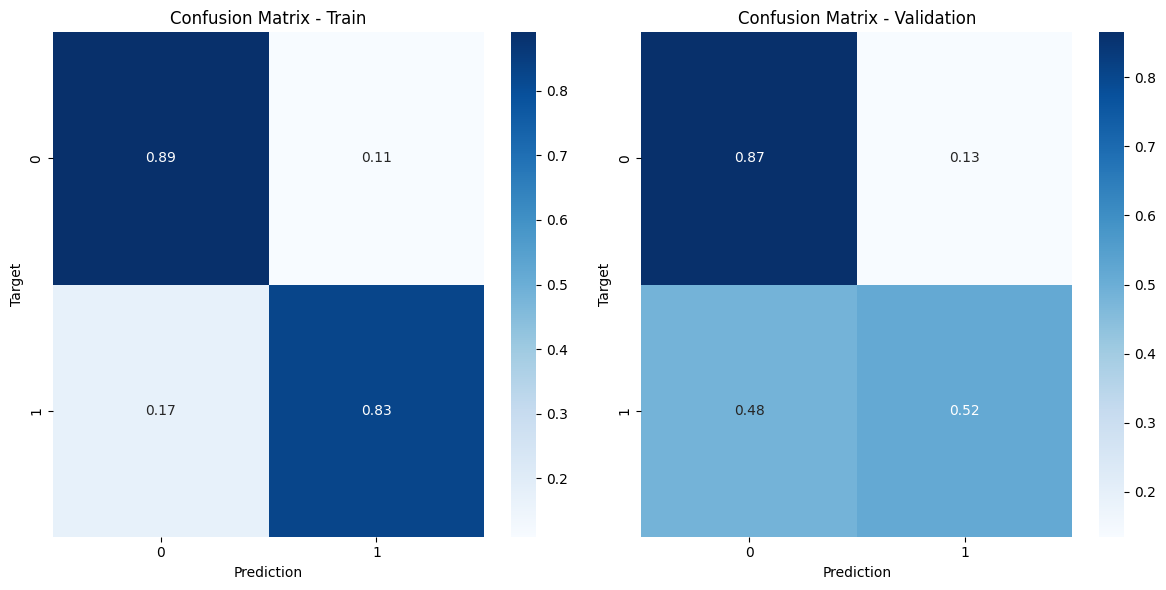

AUROC for Train dataset: 0.9414
AUROC for Validation dataset: 0.7421


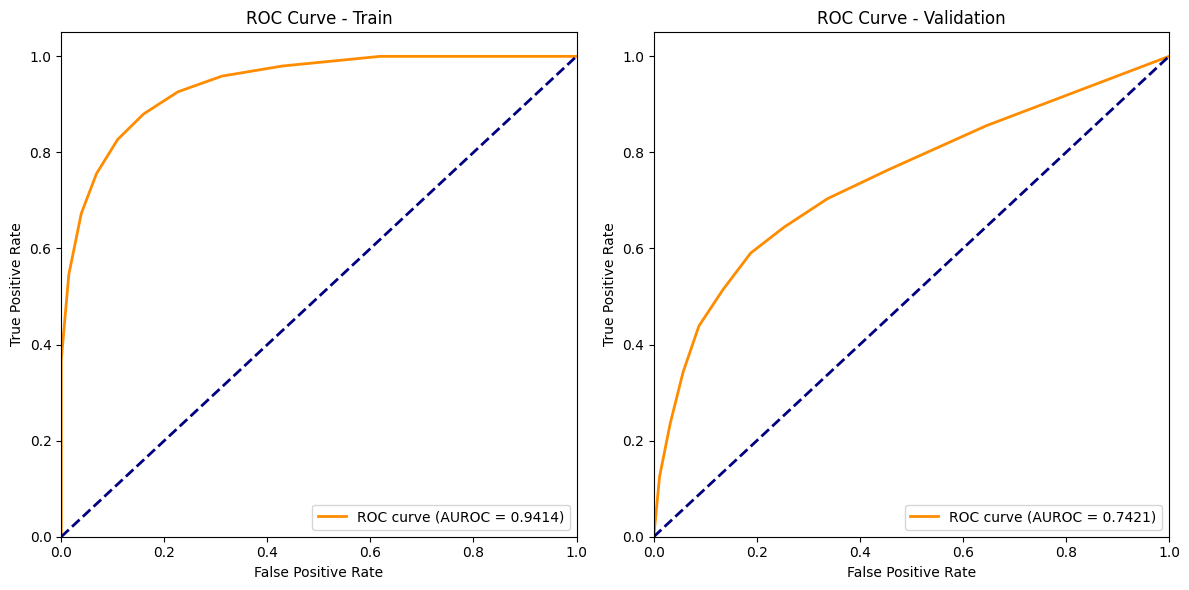

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.8084 │           0.3998 │
│ roc_auc  │      0.9414 │           0.7421 │
└──────────┴─────────────┴──────────────────┘

In [93]:
K = [3, 5, 10]
knn_models_res = {}

for k in K:
    knn_model = KNNModel(X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, n_neighbors=k).fit().predict()
    print(f"k={k}")
    model_comparator.add_model(knn_model, f"kNN k={k} with resampling")
    knn_model.display_confusion_matrix()
    knn_model.display_roc_auc()
    model_comparator.display_metrics(knn_model.compute_all_metrics())

    knn_models_res[k] = knn_model

**Загальні спостереження про моделі**:

k=3:

- Модель дуже добре передбачає негативні випадки: 89% реальних «Ні» правильно передбачено як «Ні».
- Лише 10% (та 19% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 3% (на тренуванні) та 49% (на валідації) помилково передбачені як "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує майже всі позитивні значення (~96%), але на валідації показник падає до 51%, що свідчить про сильне перенавчання.
- Бачимо значний розрив між значеннями метрик на тренувальному та валідаційному наборах даних.
- Явно виражене перенавчання – AUROC на тренуванні дуже високий, а на валідації падає.
-F1-score також суттєво зменшується, що підтверджує перенавчання.
- Загалом модель добре працює на тренувальних даних, але гірше на нових.
- Ресемплінг допоміг зменшити перекіс у класах, але модель все ще погано узагальнює.
- Краще розпізнає "Ні", ніж "Так".

k=5:

- Модель добре передбачає негативні випадки: 83% реальних «Ні» правильно передбачено як «Ні».
- Лише 16% (та 22% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 3% (на тренуванні) та 42% (на валідації) передбачено як "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 96% позитивних значень, але на валідації цей показник падає до 57%.
- Різниця між значеннями AUROC метрики для тренувального та валідаційного наборів зменшилася порівняно з k=3, але все ще є розрив між Train та Validation.
- F1-score став більш стабільним, але все ще низький.
- Загалом модель все ще демонструє перенавчання, але його рівень зменшився.
- Модель краще розпізнає "Ні", але продовжує мати проблеми з розпізнаванням "Так".

k=10:

- Модель добре передбачає негативні випадки: 80% реальних «Ні» правильно передбачено як «Ні».
- Лише 19% (та 22% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 5% (на тренуванні) та 38% (на валідації) передбачено як "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 94% позитивних значень, але на валідації цей показник падає до 61%.
- Перенавчання зменшилося, що видно по значенню метрики AUROC.
- F1-score все ще слабкий, але краще за k=3 та k=5.
- Загалом k=10 показує найкращий баланс між перенавчанням та узагальненням серед kNN з ресемплінгом.


**Загальні спостереження про модельювання за допомогою kNN на оригінальних даних без ресамплінгу**

Проведено моделювання kNN з різними значеннями k (3, 5, 10) на збалансованому датасеті. Основні висновки:

- Чим менше k (k=3), тим сильніше перенавчання – модель запам’ятовує тренувальні дані, але гірше працює на валідації.
- Чим більше k (k=10), тим краще баланс між перенавчанням та узагальненням, але все ще погано визначає позитивний клас.
- Ресемплінг допомагає вирівняти баланс класів, але не вирішує проблему низького recall для "Так".
- Навіть при збільшенні k результати не сильно покращуються – перенавчання зменшується, але якість прогнозів не досягає рівня логістичної регресії.
- kNN з ресемплінгом все ще не є ефективним для задачі передбачення підписки.

In [94]:
model_comparator.update_model_comment(knn_models_res[3],
                                      "Перенавчена модель. Ресемплінг покращив TPR для класу 1, але AUC впав з 0.99 (train) до 0.70 (val). F1-score дуже слабкий (0.34). k=3 занадто чутливе до шуму.")
model_comparator.update_model_comment(knn_models_res[5],
                                      "Перенавчена модель. Ресемплінг покращив TPR для класу 1, але AUC впав з 0.98 (train) до 0.72 (val). F1-score залишився слабким (0.35). k=5 трохи краще за k=3, але все ще неефективне.")
model_comparator.update_model_comment(knn_models_res[10],
                                      "Посередня модель. Найкраще значення AUC серед kNN з ресемплінгом (0.73 на val), але F1-score залишився слабким (0.36). k=10 зменшило перенавчання.")

### DecisionTreeModel

#### Baseline модель

Натренуємо звичайну просту модель дерева прийнятя рішеннь.

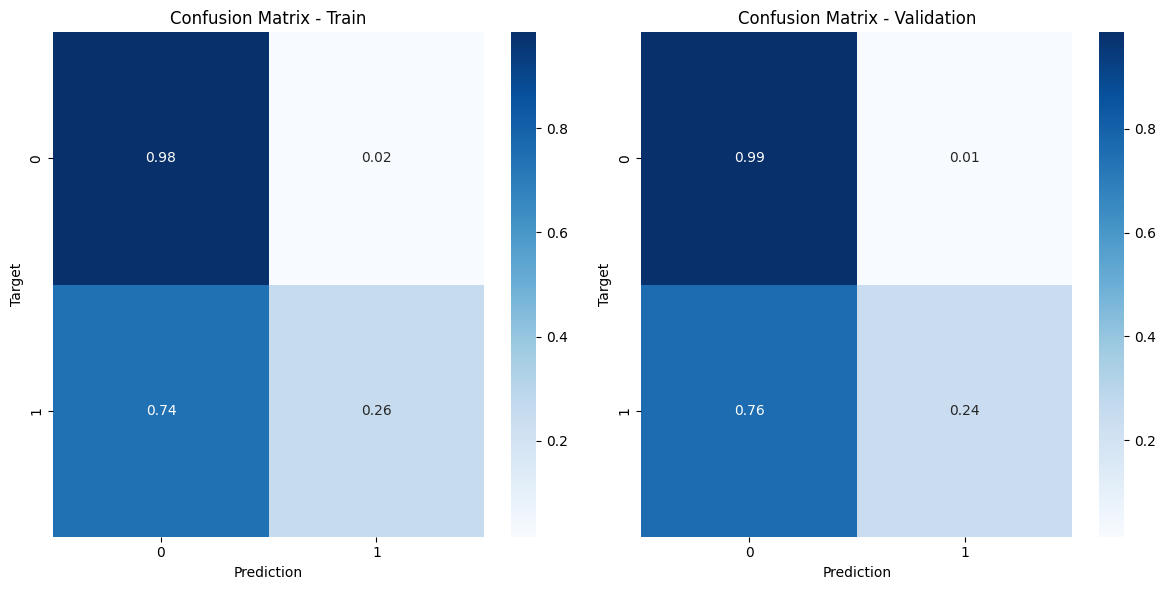

AUROC for Train dataset: 0.7854
AUROC for Validation dataset: 0.7955


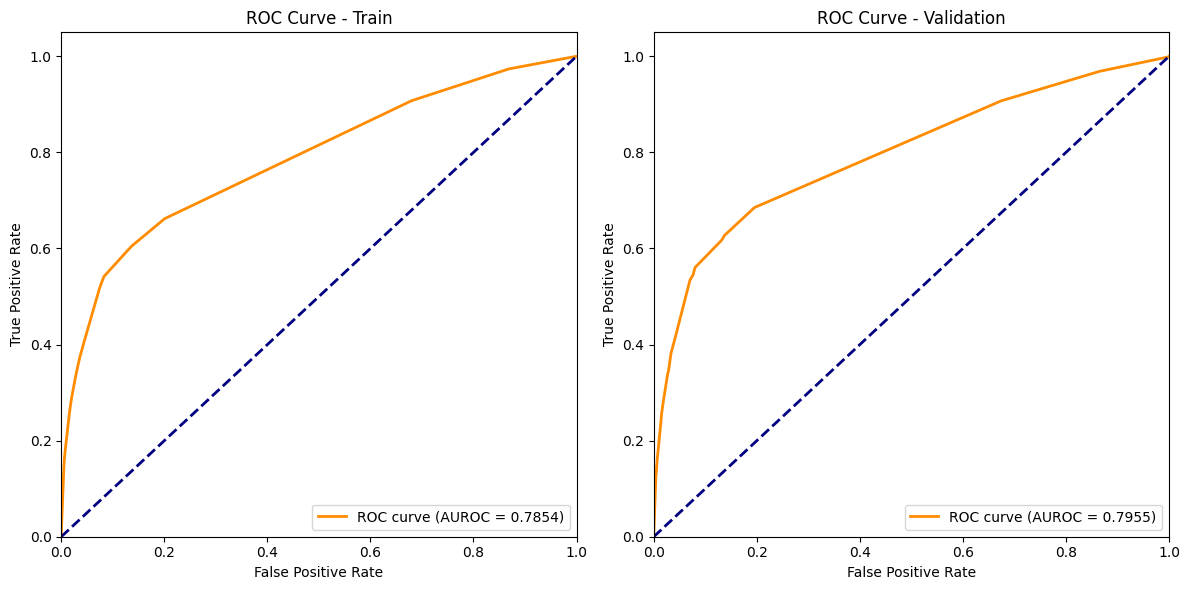

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3717 │           0.3559 │
│ roc_auc  │      0.7854 │           0.7955 │
└──────────┴─────────────┴──────────────────┘

In [95]:
tree_model_d5 = DecisionTreeModel(X_train, y_train, X_val, y_val, max_depth=5).fit().predict()
evaluate_model(tree_model_d5, "Baseline model")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (на валідаційних 1%) помилково передбачено укладання депозиту для тих, хто не уклав. Отже маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 74% (76% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 26% позитивних значень, але на валідації показник падає до 24%. Точність передбачення підписки все ще низька.
- Бачимо, що значення метрики roc auc подібні, на валідаційному наборі навіть трошки вище.
- Порівняно з KNN, дерево краще узагальнює та не перенавчається.

**Загальні спостереження про модель**:

- Дана модель працює приблизно так само, як і розглянуті моделі логістичної регресії.
- Decision Tree трохи краще моделює нелінійні залежності, але при цьому не дає значного приросту точності.
- При збільшенні max_depth, щоб покращити узагальнення, ймовірно зіштовхнемося з проблемою перенавчання моделі.

In [96]:
model_comparator.update_model_comment(tree_model_d5,
                                      "Посередня модель. Стабільна, без перенавчання, але дуже низький recall для класу 1.")

#### Model with manually tuned hyperparameters

Спробуємо вручну підбрати гіперпараметри, за застосувати крос валідацію.

Running cross-validation before training...
Cross-validation roc_auc: 0.7773 ± 0.0039


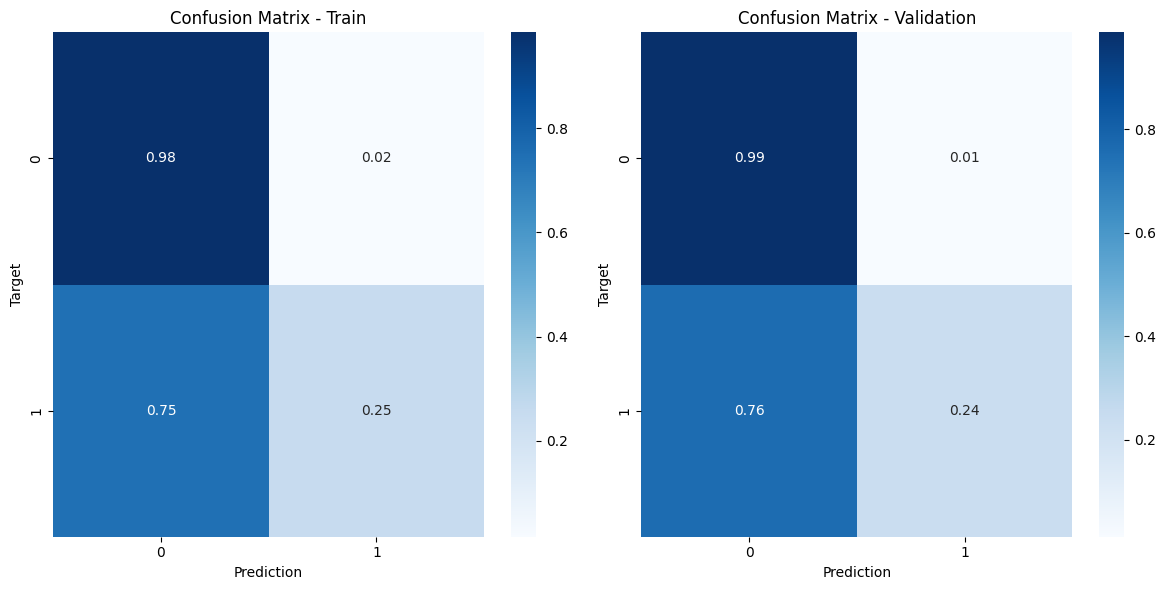

AUROC for Train dataset: 0.7853
AUROC for Validation dataset: 0.7957


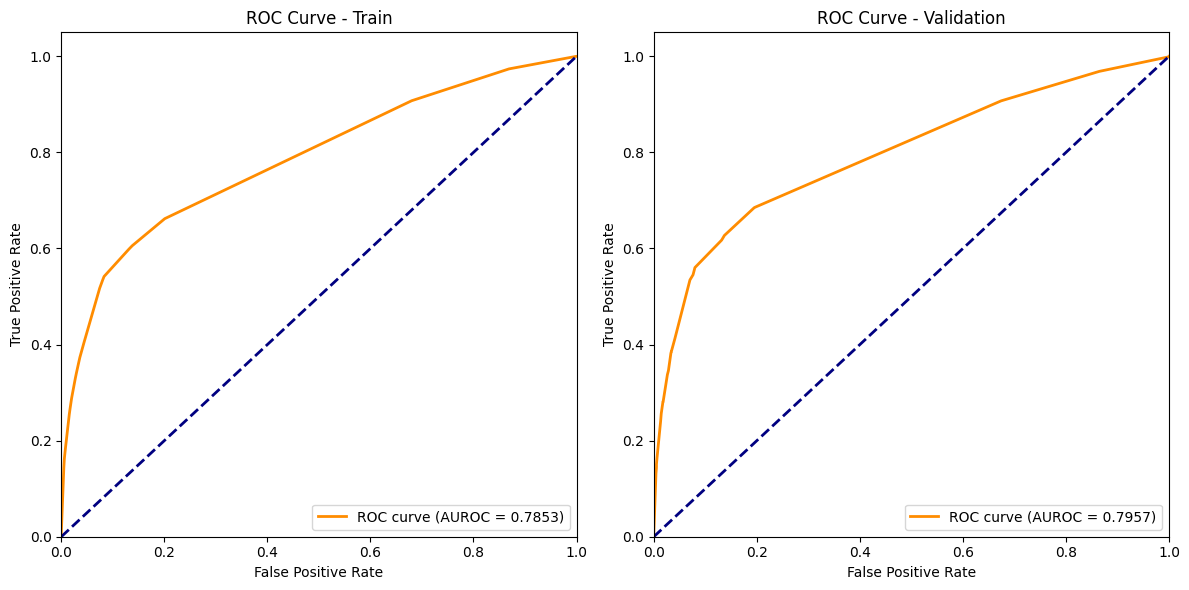

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3695 │           0.3574 │
│ roc_auc  │      0.7853 │           0.7957 │
└──────────┴─────────────┴──────────────────┘

In [97]:
dt_model_cv = DecisionTreeModel(X_train, y_train, X_val, y_val, max_depth=5, enable_cv=True,
                                min_samples_split=10, min_samples_leaf=5, cv_params={"cv": 5}
                                ).fit().predict()
evaluate_model(dt_model_cv, "Added cross validation.")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98% реальних «Ні» правильно передбачено як «Ні».
- Лише 2% (на валідаційних 1%) помилково передбачено укладання депозиту для тих, хто не уклав. Отже, маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 75% (76% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 25% позитивних значень, але на валідації показник падає до 24%. Точність передбачення підписки все ще низька.
- Бачимо, що значення метрики подібні, на валідаційному наборі навіть трошки вище.
- Загалом, можемо сказати, що модель не перенавчається.
- Модель показала дуже схожі результати на тренувальних та валідаційних даних, що означає, що вона не перенавчається.
- Значення метрики F1-score достатньо низьке.
- Модель дерева прийняття рішень показує стабільні результати, але має низьку чутливість до позитивного класу.
- Додавання крос-валідації не призвело до значного покращення, результати дуже схожі на baseline дерево рішень.


In [98]:
model_comparator.update_model_comment(dt_model_cv,
                                      "Посередня модель. Крос-валідація трохи стабілізувала AUROC, але якість прогнозів не покращилась. Recall для класу 1 залишається низьким.")

#### Model with manually tuned hyperparameters and resampling

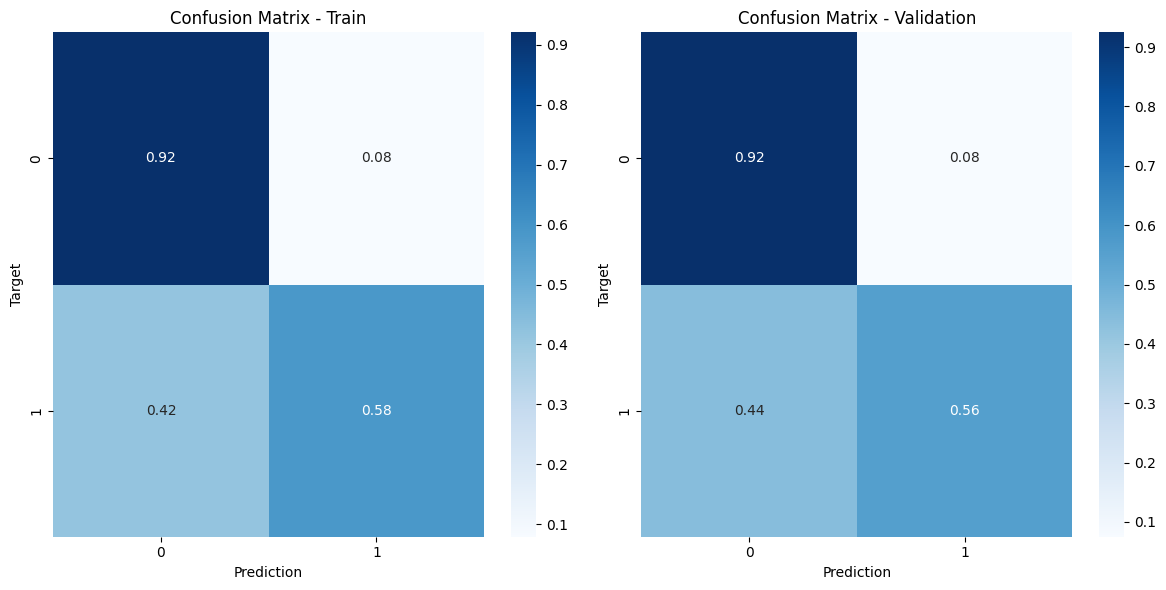

AUROC for Train dataset: 0.8046
AUROC for Validation dataset: 0.7805


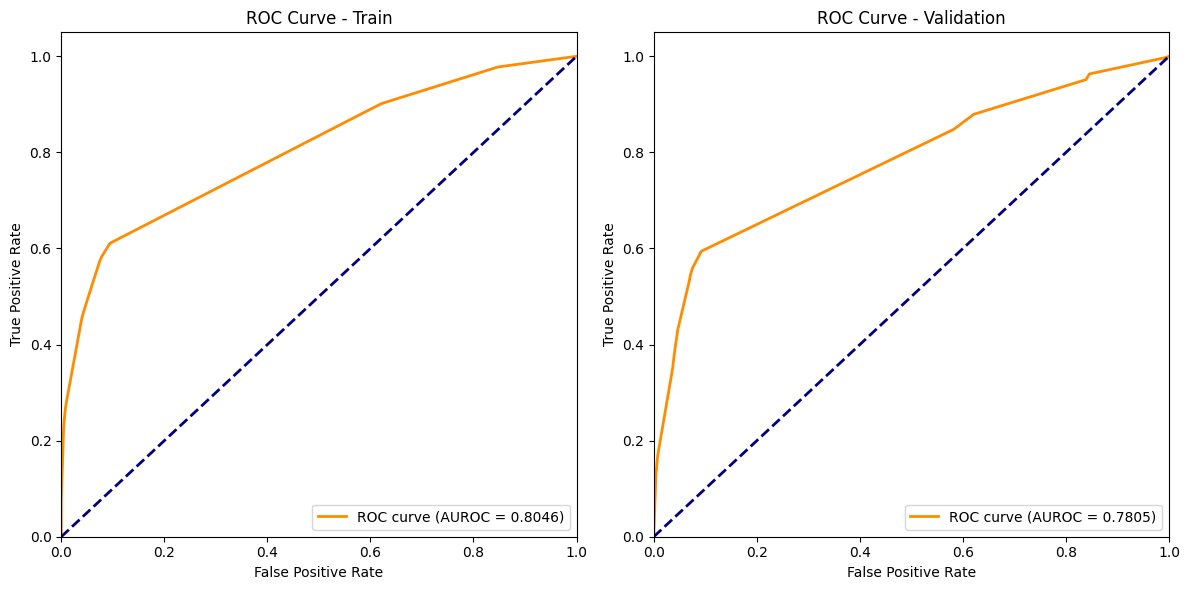

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.6705 │           0.5200 │
│ roc_auc  │      0.8046 │           0.7805 │
└──────────┴─────────────┴──────────────────┘

In [99]:
dt_model_rs = DecisionTreeModel(
    X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, max_depth=5, min_samples_split=10,
    min_samples_leaf=5).fit().predict()
evaluate_model(dt_model_rs, "With resampling.")

**Спостереження**:

- Модель добре передбачає негативні випадки: 91.8% реальних "Ні" правильно передбачено як "Ні".
- 8.2% (та 8.5% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Пропущених позитивних випадків значно менше, ніж у попередніх моделях: 39% (на тренуванні) → 44.9% (на валідації) класифіковані неправильно.
- AUROC зросло на тренувальних даних та залишилося стабільним на валідації.
- Бачимо значне падіння F1 на валідації, що вказує на перенавчання.
- Модель краще розпізнає клас "Так", ніж у попередніх версіях DecisionTree, але маємо перенавчання моделі.
- Ресемплінг допоміг покращити баланс між класами, але все ще є занижений recall для класу "Так".

In [100]:
model_comparator.update_model_comment(dt_model_rs,
                                      "Хороша модель, але з перенавчанням. Ресемплінг покращив баланс класів, але AUROC на валідації залишився посереднім.")

### RandomForest

#### Baseline model

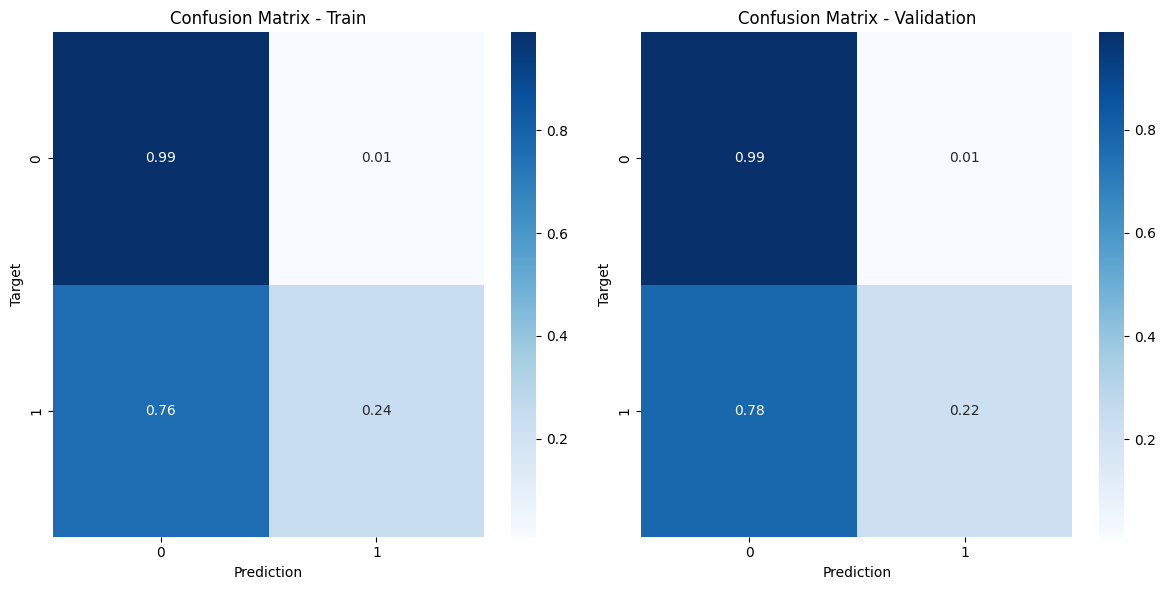

AUROC for Train dataset: 0.8379
AUROC for Validation dataset: 0.8097


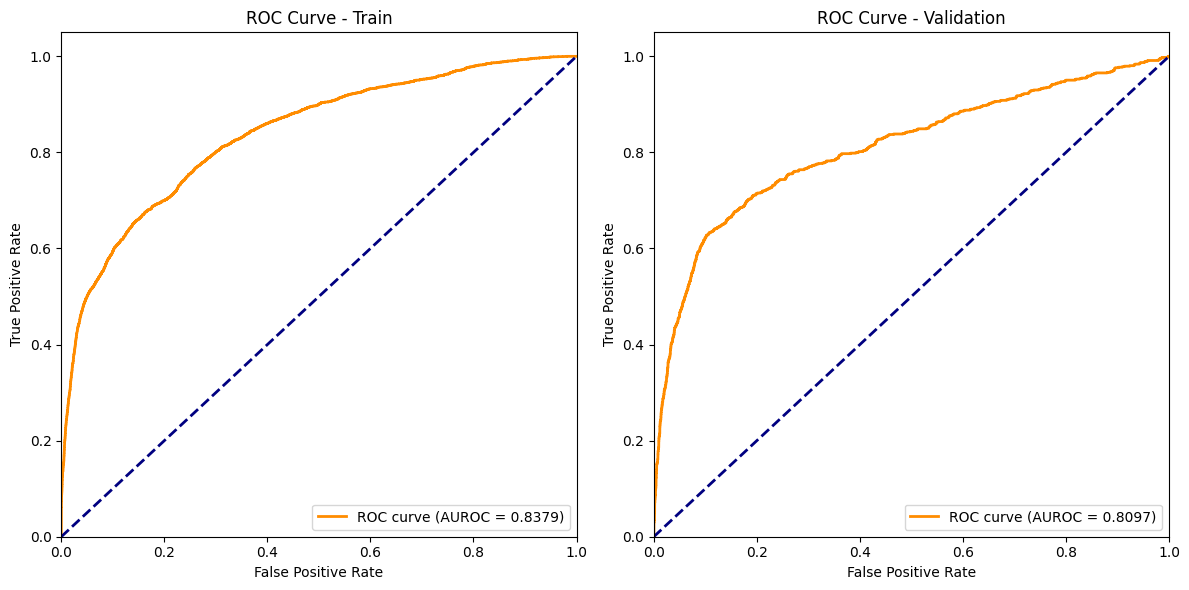

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3670 │           0.3336 │
│ roc_auc  │      0.8379 │           0.8097 │
└──────────┴─────────────┴──────────────────┘

In [101]:
rf_model = RandomForestModel(X_train, y_train, X_val, y_val, n_estimators=150, max_depth=10, min_samples_split=5,
                             min_samples_leaf=10).fit().predict()
evaluate_model(rf_model, "Baseline model")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 99% реальних «Ні» правильно передбачено як «Ні».
- Лише 1%  помилково передбачено укладання депозиту для тих, хто не уклав. Отже, маємо дуже низький рівень помилкових позитивних передбачень.
- Дуже високий відсоток пропущених позитивних випадків 76% (78% на валідаційному наборі) помилково передбачені "Ні", коли насправді "Так".
- У тренувальній вибірці модель вгадує 24% позитивних значень, але на валідації показник падає до 22%. Точність передбачення підписки все ще низька.
- Бачимо, що зі використанням RandomForest значення метрики roc-auc підвищилось, відносно бвзових моделей.
- Присутній невелика різниця в значеннях для тренувального та валідаційного наборів.
- Отже, мажмо перенавчання, але вже не таке сильне як у попередніх моделей.
- Модель продемонструвала вищу якість за попередні, хоча модель перенавчилася.
- Проблема визначення позитивного класу все ще актуальна.

In [102]:
model_comparator.update_model_comment(rf_model,
                                      "Хороша модель за AUROC, але слабкий F1-score. Добре розпізнає клас 'Ні', але погано класифікує 'Так'.")

#### Model with resampling

Спробуємо застосувати ресамплінг

Running cross-validation before training...
Cross-validation roc_auc: 0.9507 ± 0.0038


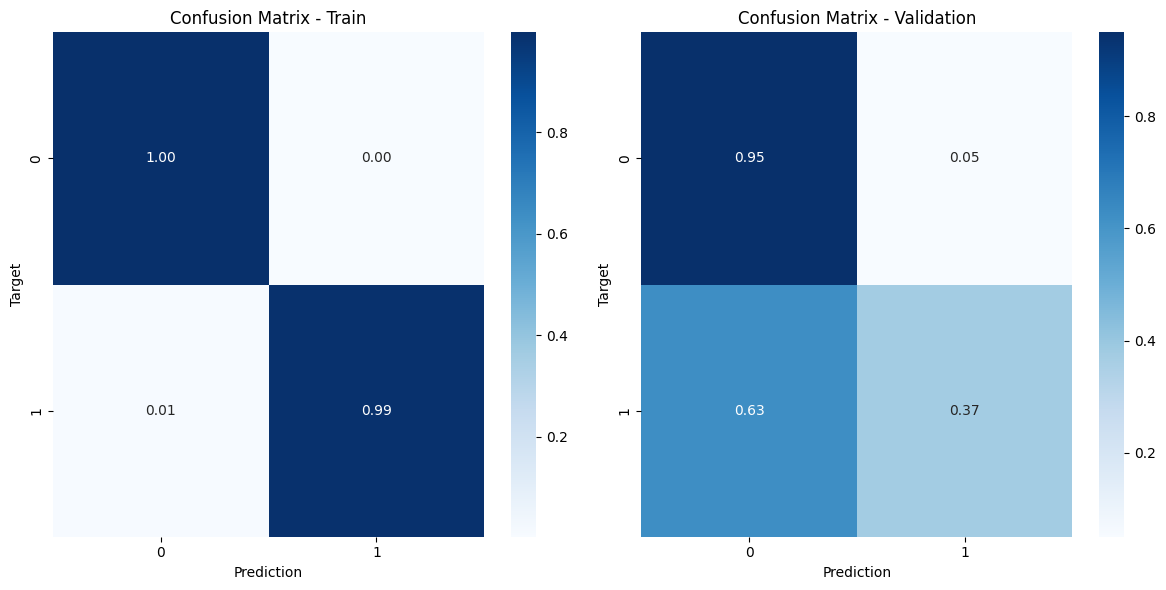

AUROC for Train dataset: 0.9999
AUROC for Validation dataset: 0.7766


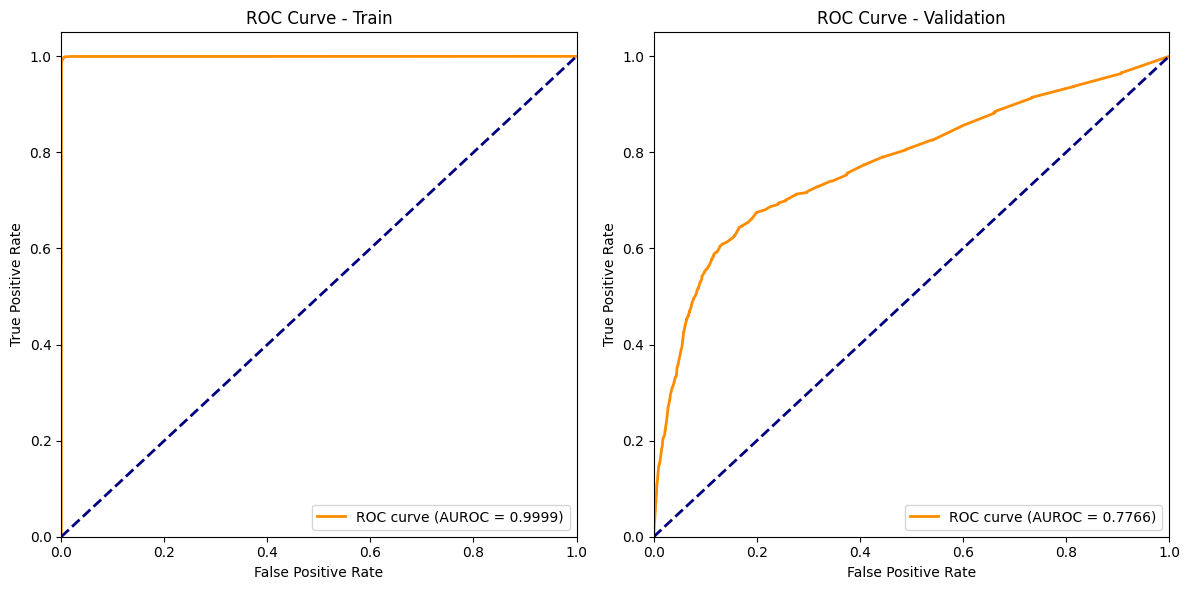

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.9944 │           0.4232 │
│ roc_auc  │      0.9999 │           0.7766 │
└──────────┴─────────────┴──────────────────┘

In [103]:
rf_params = {"n_estimators": 100, "max_depth": 10, "min_samples_split":5, "min_samples_leaf":10}

rf_model_rs_sm = RandomForestModel(X_t_resampled_smotenc, y_t_resampled_smotenc, X_val, y_val, rf_params).fit().predict()
evaluate_model(rf_model_rs_sm, "With data resampling.")

**Спостереження**:

- Модель добре передбачає негативні випадки
- AUROC зросло на тренувальних даних та залишилося стабільним на валідації.
- Маємо значне падіння F1 на валідації, що вказує на перенавчання, але все ж таки краще, ніж у базовій версії.
- Ресемплінг допоміг покращити баланс між класами, що видно по значному покращенню F1-score.
- AUROC залишився високим (0.80+), що є хорошим результатом, але має місце і перенавчання.

Варто зазначити, що модель не є стабліьною, до того схильна до пренавчання, тому в даному вигляді не може бути використана

In [104]:
model_comparator.update_model_comment(rf_model_rs_sm,
                                      "Хороша модель. Не може бути використана через не стабільність і схильність до перенавчання. Ресемплінг покращив баланс класів: F1-score зріс.")

### XGBModel

#### Baseline XGBModel

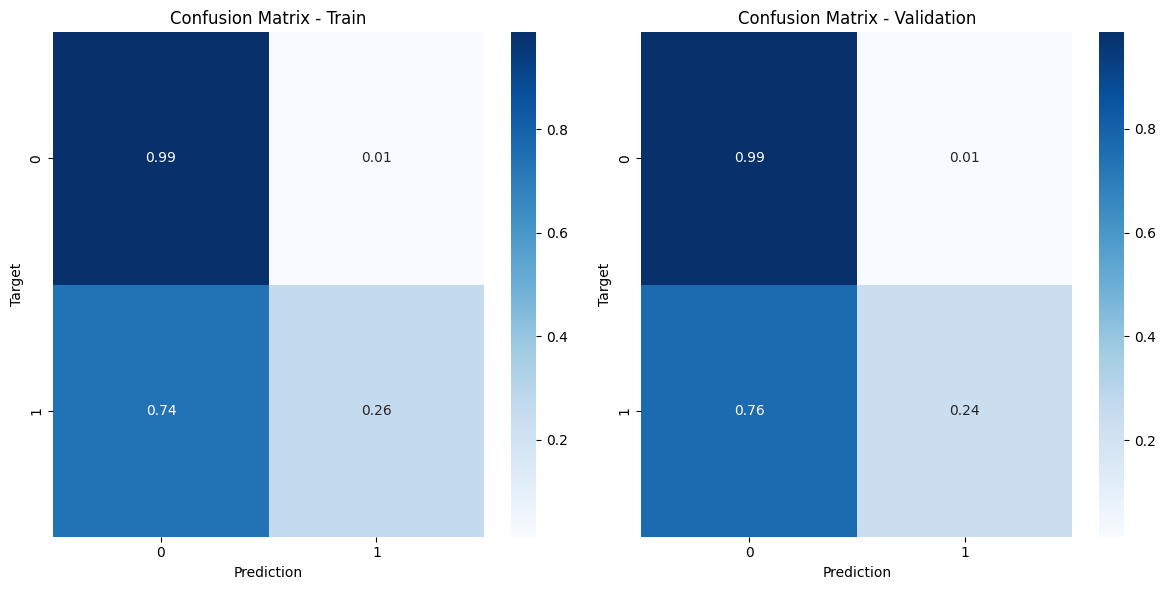

AUROC for Train dataset: 0.8203
AUROC for Validation dataset: 0.8147


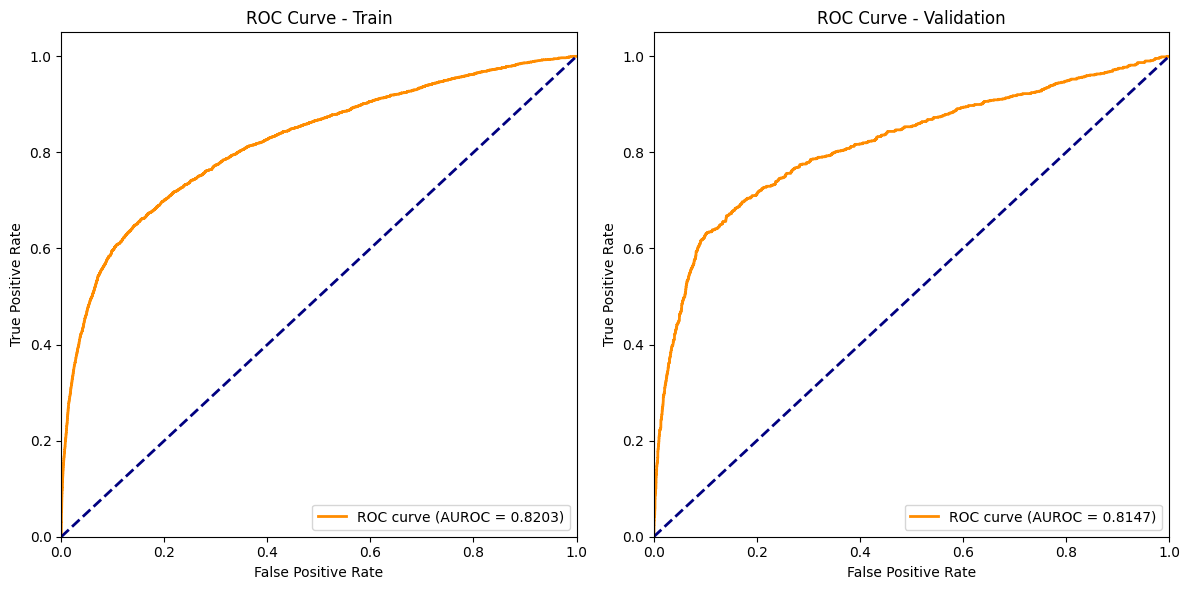

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3825 │           0.3523 │
│ roc_auc  │      0.8203 │           0.8147 │
└──────────┴─────────────┴──────────────────┘

In [105]:
xgb_model_params = {"learning_rate": 0.05, "n_estimators": 150, "max_depth": 4}
xgb_model = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                     params=xgb_model_params).fit().predict()
evaluate_model(xgb_model, "Baseline model")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 98.7% реальних "Ні" правильно передбачено як "Ні".
- Лише 1.3% помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 73.9% (на тренуванні) → 76.3% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зі значень метрики AUROC бачимо стабільність, без значного перенавчання.
- Значення метркии F1-score все ще слабке.
- Модель не демонструє сильного перенавчання, але все ще погано розпізнає позитивний клас.
- XGBoost показує хороший баланс між навчальною та тестовою вибірками.
- F1-score залишається низьким, що говорить про проблеми з точним передбаченням класу "Так".
- Модель працює стабільніше, ніж попередні алгоритми, але ще потребує покращення.

In [106]:
model_comparator.update_model_comment(xgb_model,
                                      "Хороша модель. Високий AUROC, стабільна без перенавчання. F1-score все ще слабкий, що вказує на проблеми з розпізнаванням позитивного класу.")

#### XGBModel with tuning hyperparameters via RandomizedSearchCV

In [165]:
xgb_space_random = {
    'n_estimators': np.arange(50, 300, 25),
    'learning_rate': np.linspace(0.01, 0.05, 10),
    'max_depth': np.arange(3, 7, 1),
    'min_child_weight': np.arange(5, 15, 1),
    'subsample': np.linspace(0.5, 0.8, 10),
    'colsample_bytree': np.linspace(0.5, 0.9, 10),
    'gamma': np.linspace(0.1, 1.0, 10),
    'reg_alpha': np.linspace(0.5, 2.0, 10),
    'reg_lambda': np.linspace(0.5, 2.0, 10)
}

In [108]:
tuner_random_xgb = RandomSearchTuner(XGBClassifier, X_train, y_train, X_val, y_val, xgb_space_random)
best_params_random_xgb = tuner_random_xgb.tune()

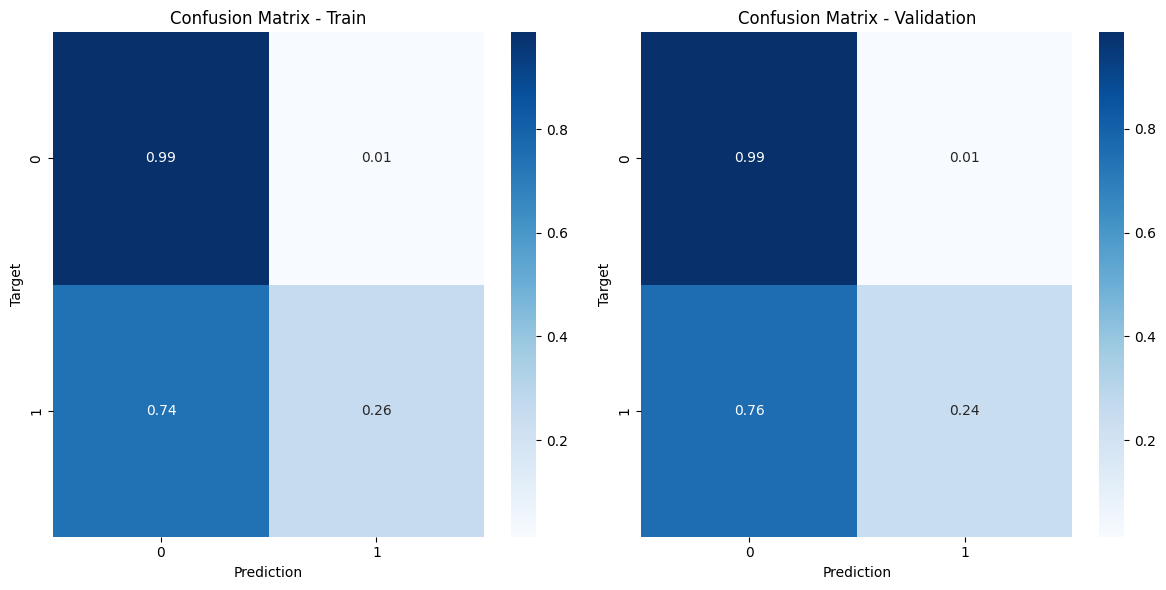

AUROC for Train dataset: 0.8213
AUROC for Validation dataset: 0.8151


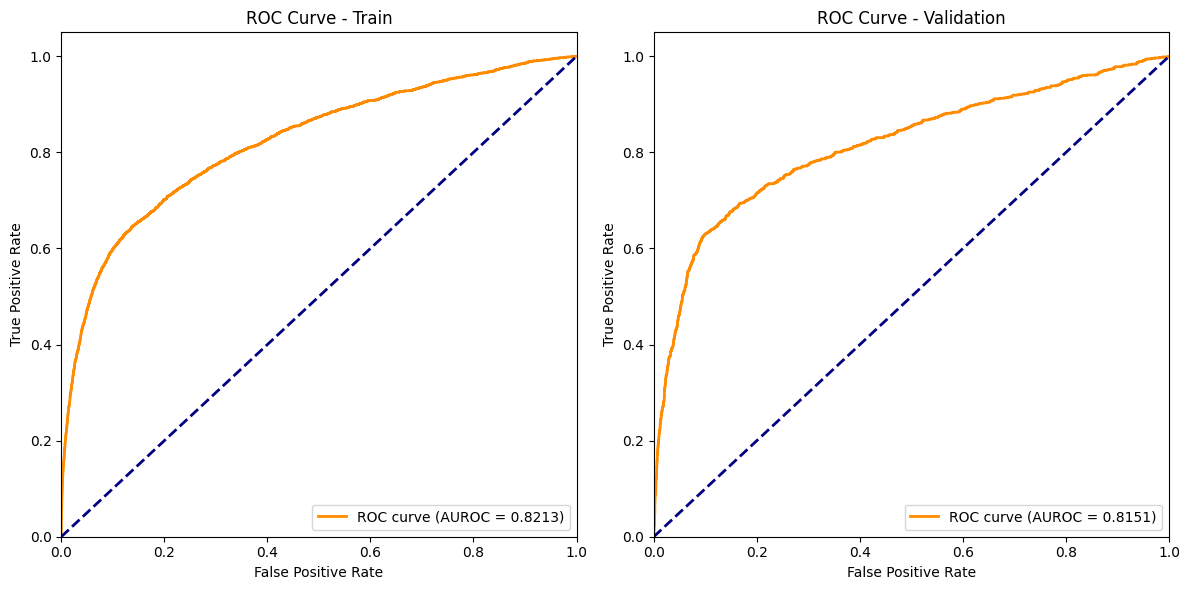

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.3791 │           0.3620 │
│ roc_auc  │      0.8213 │           0.8151 │
└──────────┴─────────────┴──────────────────┘

In [109]:
xgb_model_r = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                       params=best_params_random_xgb).fit().predict()
evaluate_model(xgb_model_r, "With RandomizedSearchCV tuning")

**Спостереження**:

- Модель дуже добре передбачає негативні випадки: 99% реальних "Ні" правильно передбачено як "Ні".
- Лише 1% помилково передбачено укладання депозиту для тих, хто не уклав.
- Високий відсоток пропущених позитивних випадків: 74% (на тренуванні) → 76% (на валідації) передбачено як "Ні", коли насправді "Так".
- Значення метркии AUROC стабільнеь, без значного перенавчання.
- Модель не демонструє сильного перенавчання, але все ще погано розпізнає позитивний клас.
- Налаштування гіперпараметрів за допомогою RandomizedSearchCV не призвело до значного покращення.
- XGBoost після RandomizedSearchCV зберіг стабільність і високий AUROC, але не покращив F1-score.
- Гіперпараметричний тюнінг не дав значного покращення в продуктивності.
- Модель залишається стабільною, але потребує додаткової оптимізації для кращого балансу між precision та recall.

In [110]:
model_comparator.update_model_comment(xgb_model_r,
                                      "Хороша модель. Після RandomizedSearchCV AUROC залишився стабільним, але F1-score все ще слабкий. Оптимізація не дала значного покращення.")

#### XGBModel with tuning hyperparameters via RandomizedSearchCV and resampling

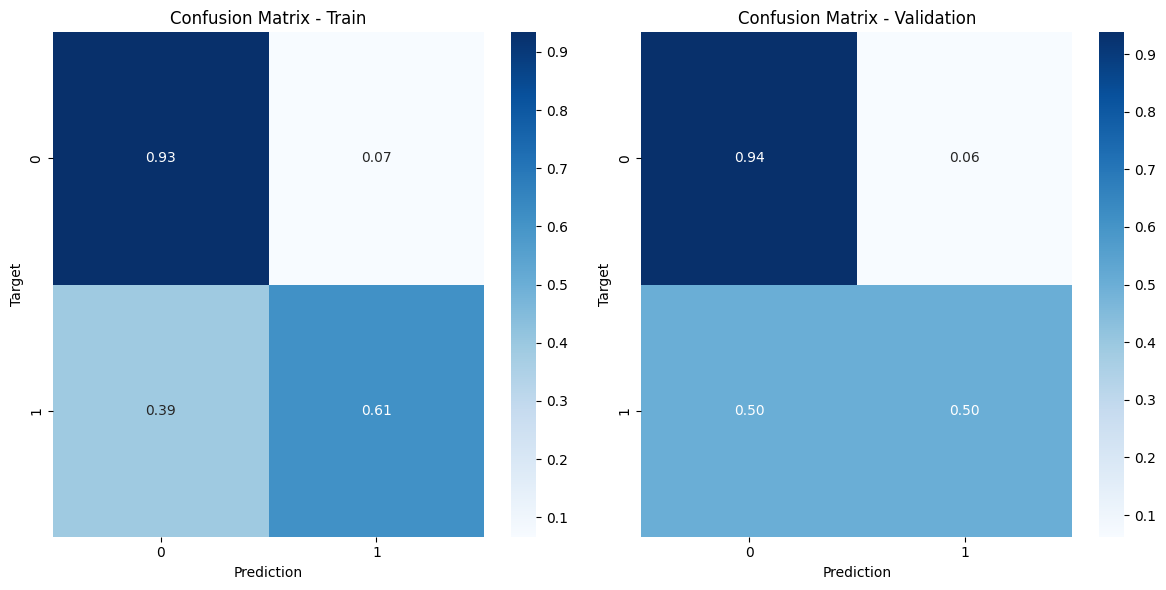

AUROC for Train dataset: 0.8916
AUROC for Validation dataset: 0.7973


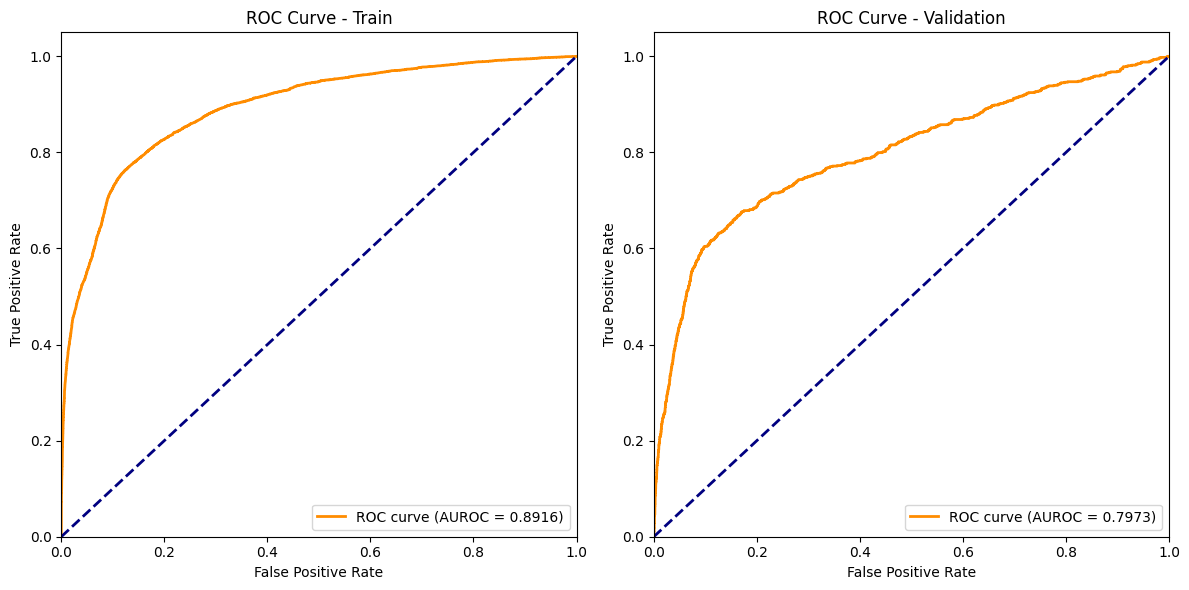

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.6997 │           0.5022 │
│ roc_auc  │      0.8916 │           0.7973 │
└──────────┴─────────────┴──────────────────┘

In [111]:
xgb_model_r_s = XGBModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val,
                         params=best_params_random_xgb).fit().predict()
evaluate_model(xgb_model_r_s, "With RandomizedSearchCV tuning")

**Спостереження**:

- Модель добре передбачає негативні випадки: 90.7% реальних "Ні" правильно передбачено як "Ні".
- Лише 9.3% (та 9.6% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Пропущених позитивних випадків значно менше, ніж у попередніх моделях:22.5% (на тренуванні) → 44.3% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зачнння AUROC демонструє значне AUROC на тренуванні, але все значно нижщий на валідації.
- Для F1-score маємо значне падіння F1 на валідації, що вказує на певне перенавчання.
- Ресемплінг суттєво покращив здатність розпізнавати позитивний клас, але перенавчання все ще присутнє.
- F1-score значно зріс на тренуванні (0.83), але на валідації залишився нижчим за 0.50, що вказує на складність узагальнення.

In [112]:
model_comparator.update_model_comment(xgb_model_r_s,
                                      "Хороша модель з певним перенавчанням. Ресемплінг покращив баланс класів: AUROC зріс, F1-score покращився, але все ще нижчий за 0.50 на валідації.")

#### XGBModel with tuning hyperparameters via Hyperopt

In [166]:
tuner_hyperopt_xgb = HyperoptTuner(XGBClassifier, X_train, y_train, X_val, y_val, xgb_space_random)
best_params_hyperopt_xgb = tuner_hyperopt_xgb.tune()

100%|██████████| 20/20 [00:24<00:00,  1.22s/trial, best loss: -0.8158003473041182]


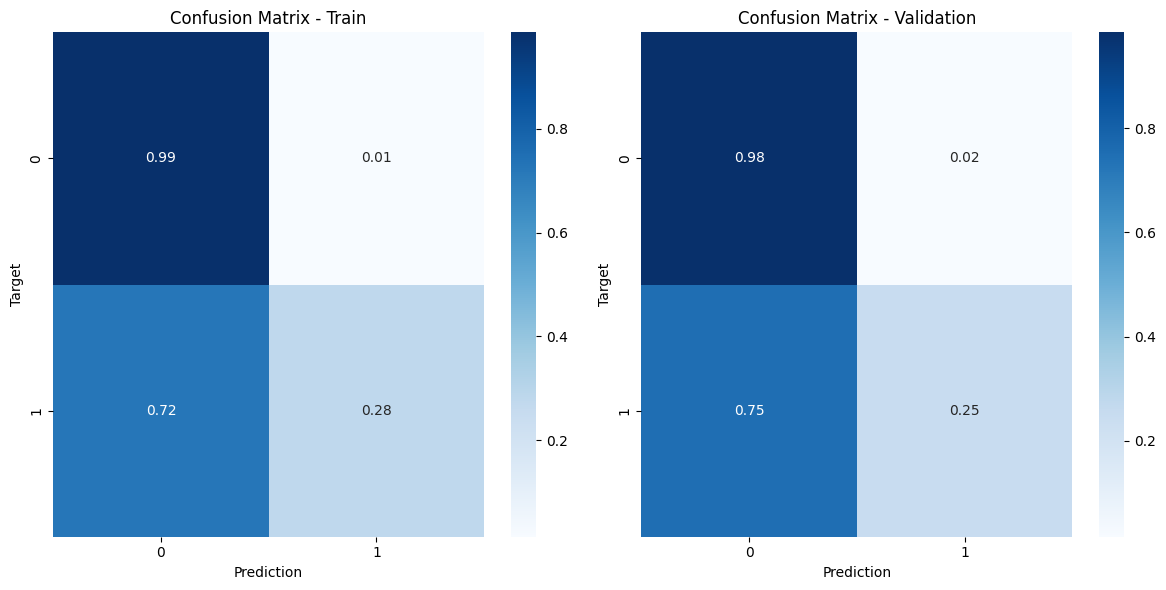

AUROC for Train dataset: 0.8346
AUROC for Validation dataset: 0.8158


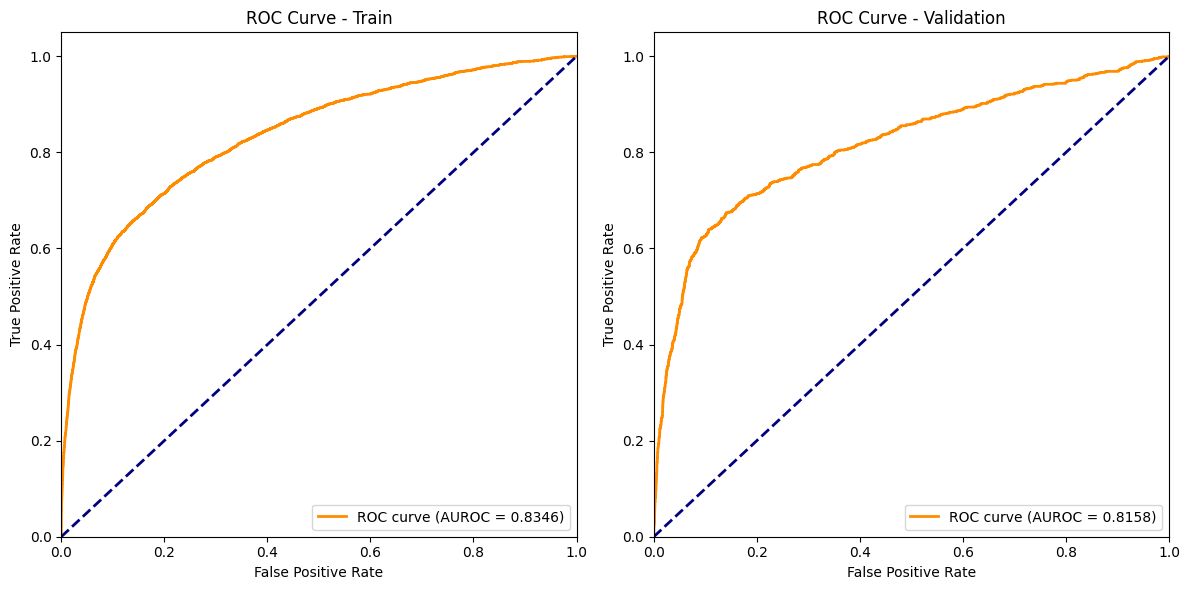

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4002 │           0.3616 │
│ roc_auc  │      0.8346 │           0.8158 │
└──────────┴─────────────┴──────────────────┘

In [167]:
xgb_model_h = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                       params=best_params_hyperopt_xgb).fit().predict()
evaluate_model(xgb_model_h, "With Hyperopt tuning")

**Спостереження**:
- Модель добре передбачає негативні випадки: 98.4% реальних "Ні" правильно передбачено як "Ні".
- Лише 1.4% (та 1.6% на валідаційних) помилково передбачено укладання депозиту для тих, хто не уклав.
- Пропущених позитивних випадків 71.2% (на тренуванні) → 75.0% (на валідації) передбачено як "Ні", коли насправді "Так".
- Модель не демонструє сильного перенавчання, але все ще має проблеми з розпізнаванням позитивного класу.
- Гіперпараметричний тюнінг через Hyperopt трохи покращив F1-score і стабілізував AUROC.
- Hyperopt допоміг знайти трохи кращі параметри для F1-score та стабільності AUROC.
- F1-score покращився порівняно з попередніми версіями XGBoost, але все ще не ідеальний.
- Ця версія XGBoost демонструє кращий баланс між узагальненням і продуктивністю.

In [115]:
model_comparator.update_model_comment(xgb_model_h,
                                      "Хороша модель. Hyperopt стабілізував AUROC та трохи покращив F1-score. Все ще є проблеми з розпізнаванням позитивного класу.")

#### XGBModel with tuning hyperparameters via Hyperopt with resampling

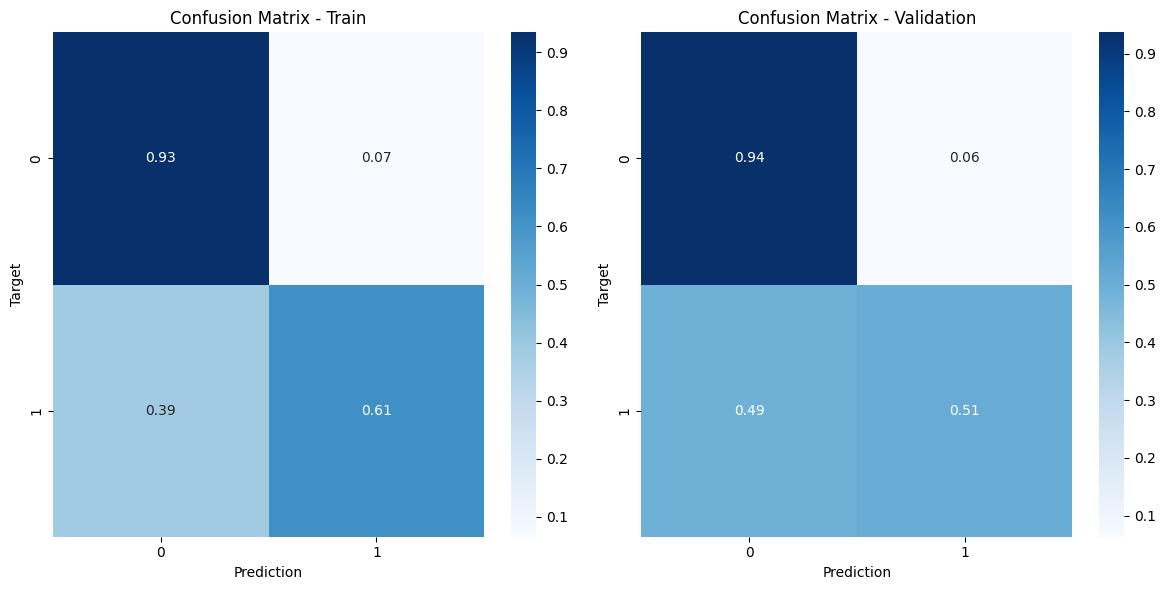

AUROC for Train dataset: 0.8945
AUROC for Validation dataset: 0.7996


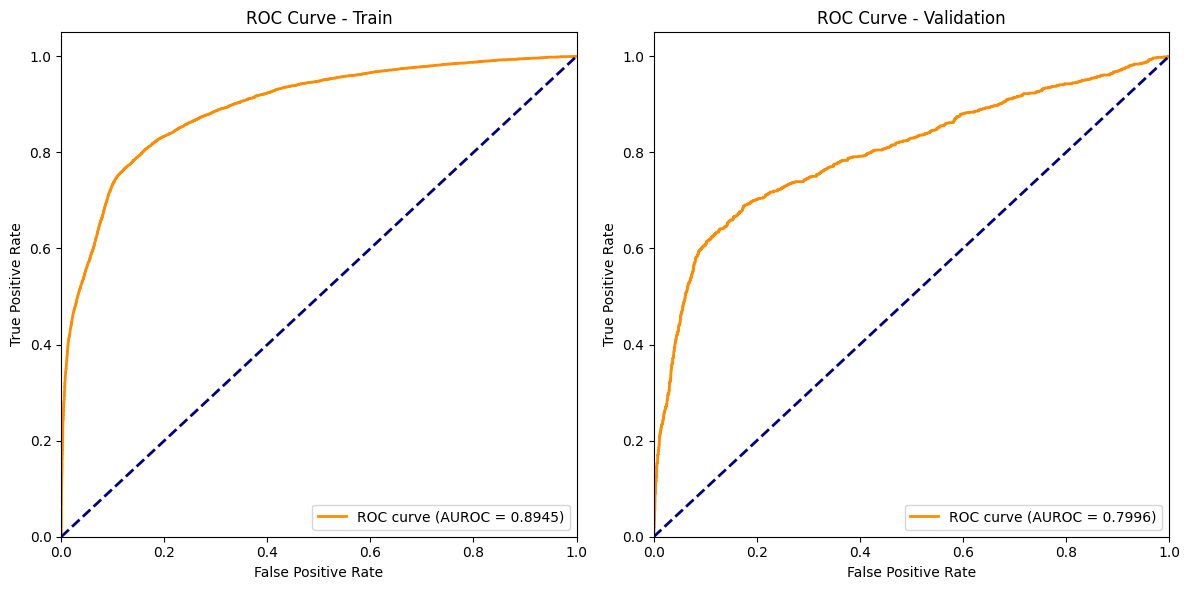

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7041 │           0.5067 │
│ roc_auc  │      0.8945 │           0.7996 │
└──────────┴─────────────┴──────────────────┘

In [116]:
xgb_model_h_rs = XGBModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val,
                       params=best_params_hyperopt_xgb).fit().predict()
evaluate_model(xgb_model_h_rs, "With Hyperopt tuning")

**Спостереження**:

- Модель добре передбачає "негативні" випадки "Ні", як у тренувальному, так і у валідаційному наборі.
- Хоча після ресемплінгу показник Recall для класу Yes покращився, у валідаційних даних модель все ще неправильно класифікує половину позитивних випадків.
- На валідаційних даних AUC помітно знижується, маємо явне перенавчання.
- Помітне падіння F1-score на валідації (~0.50), що вказує на проблеми з балансом precision/recall.
- Модель не оптимально працює з класом "Так"

In [117]:
model_comparator.update_model_comment(xgb_model_h_rs,
                                      "Хороша модель. Все ще є проблеми з розпізнаванням позитивного класу. Наявне перенавчання - можна покращити узагальнюючу здатність.")

### LGBMModel

#### Baseline model

[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898


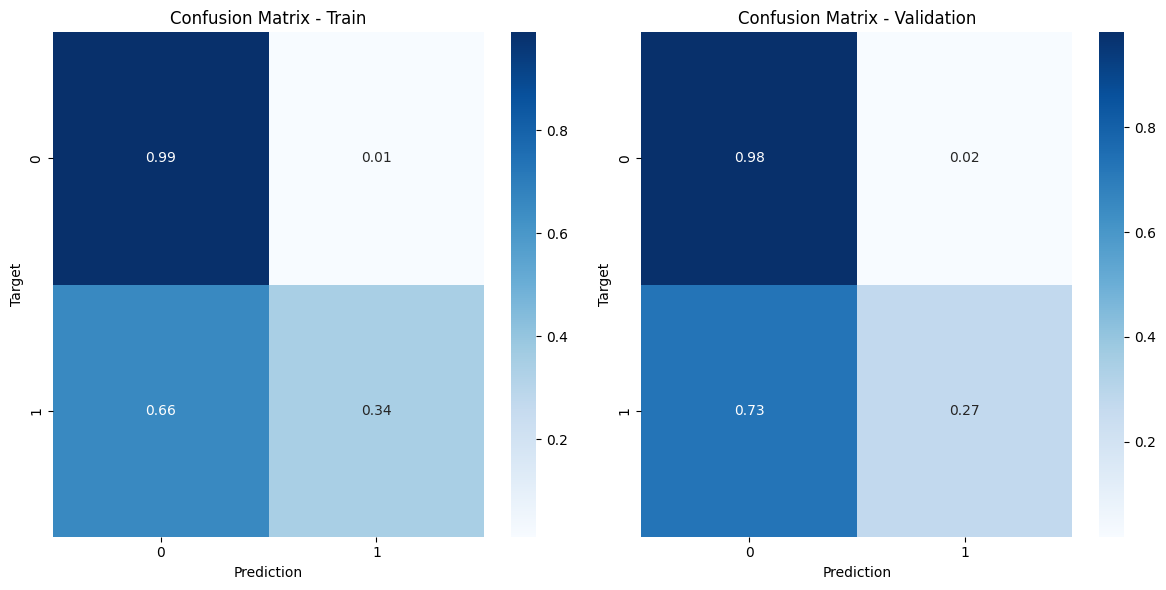

AUROC for Train dataset: 0.8943
AUROC for Validation dataset: 0.8129


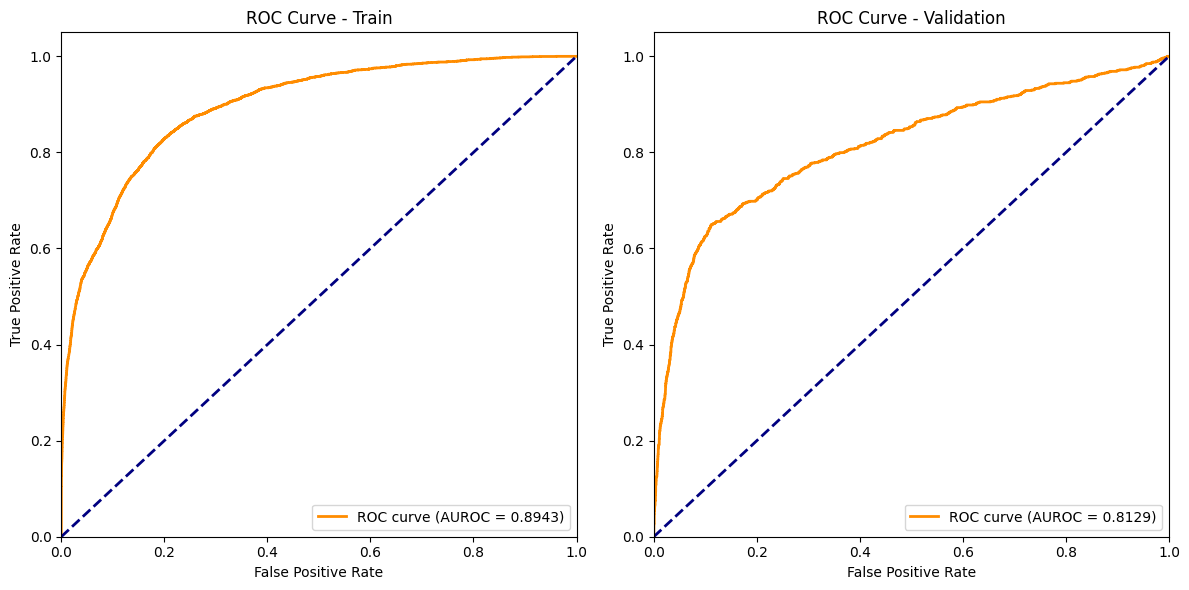

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4821 │           0.3823 │
│ roc_auc  │      0.8943 │           0.8129 │
└──────────┴─────────────┴──────────────────┘

In [118]:
lgbm_model_params = {"learning_rate": 0.05, "n_estimators": 200, "num_leaves": 40}
lgbm_model = LGBMModel(
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val, params=lgbm_model_params
).fit().predict()

evaluate_model(lgbm_model, "Baseline model.")

**Спостереження**:
- Модель дуже добре передбачає негативні випадки: 98% реальних "Ні" правильно передбачено як "Ні".
- Лише 2% (та 1.0% на тренуванні) помилково передбачено укладання депозиту для тих, хто не уклав.
- 66% (на тренуванні) → 73% (на валідації) передбачено як "Ні", коли насправді "Так".
- Значення AUROC має розрив на тренуванні та валідації, що свідчить про перенавчання.
- F1-score порівняно краще, ніж у XGBoost, але все ще низький.
- Модель виглядає попередньо кращою за XGBoost у загальному розрізі, але перенавчання присутнє.
- F1-score все ще потребує покращення, оскільки модель має проблеми з передбаченням класу "Так".

In [119]:
model_comparator.update_model_comment(lgbm_model,
                                      "Хороша модель. Високий AUROC, але F1-score залишається низьким. Дещо є перенавчання, потрібно покращити балансування.")

#### LGBMModel with tuning hyperparameters via RandomizedSearchCV

In [120]:
lgb_space_rs = {
    'n_estimators': np.arange(50, 500, 25).astype(int),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 1).astype(int),
    'min_child_weight': np.arange(1, 11, 1).astype(int),
    'subsample': np.clip(np.linspace(0.5, 1.0, 10), 0.5, 1.0),
    'colsample_bytree': np.clip(np.linspace(0.5, 1.0, 10), 0.5, 1.0),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10),
    'min_split_gain': np.clip(np.linspace(0.001, 0.1, 10), 0.001, 0.1)  # Уникаємо 0
}

In [146]:
tuner_random_lgb = RandomSearchTuner(LGBMClassifier, X_train, y_train, X_val, y_val, lgb_space_rs)
best_params_random_lgb = tuner_random_lgb.tune()

In [147]:
lgb_model_r = LGBMModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                        params=best_params_random_lgb).fit().predict()

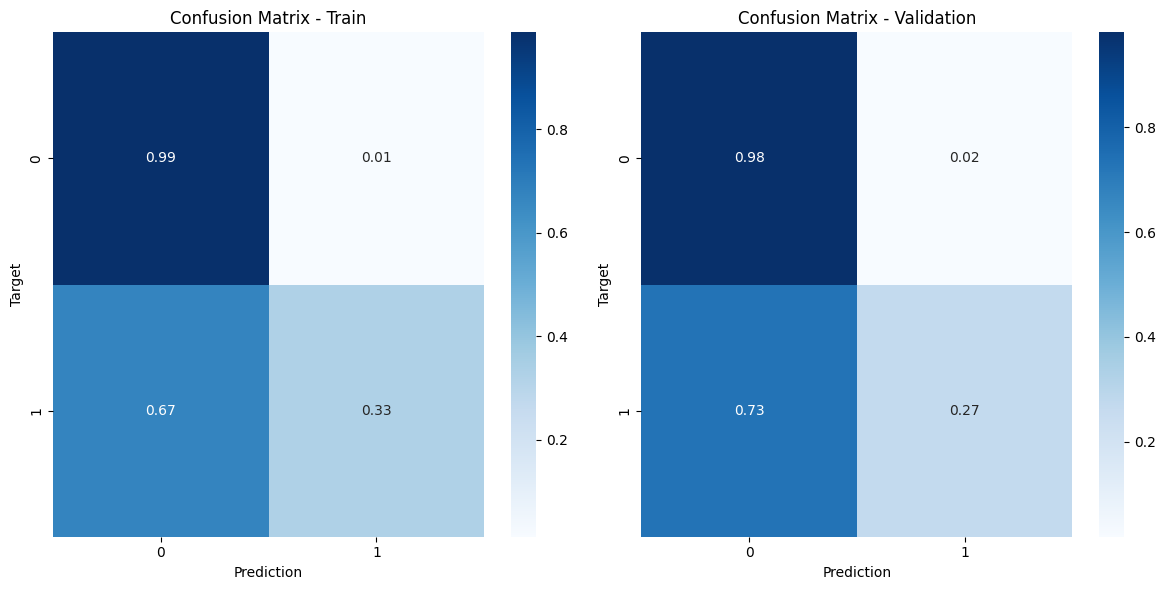

AUROC for Train dataset: 0.8785
AUROC for Validation dataset: 0.8115


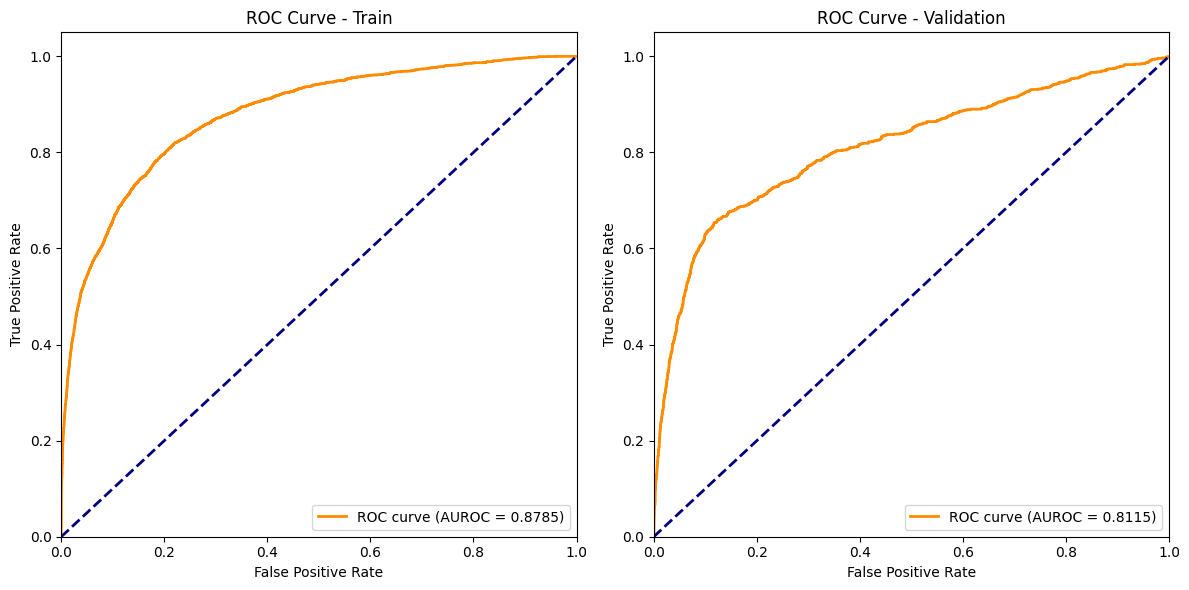

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4591 │           0.3786 │
│ roc_auc  │      0.8785 │           0.8115 │
└──────────┴─────────────┴──────────────────┘

In [148]:
evaluate_model(lgb_model_r, "With RandomizedSearchCV tuning")

**Спостереження**:

- Модель добре передбачає негативні випадки: 98% реальних "Ні" правильно передбачено як "Ні".
- Лише 2% помилково передбачено укладання депозиту для тих, хто не уклав.
- 72.2% (на тренуванні) та 74.0% (на валідації) передбачено як "Ні", коли насправді "Так".
- Бачимо, зі значення AUROC відмінна стабільність, без значного перенавчання.
- F1-score трохи покращився у порівнянні з базовим LightGBM.
- Модель не демонструє сильного перенавчання, але все ще має проблеми з розпізнаванням позитивного класу.
- Гіперпараметричний тюнінг через RandomizedSearchCV трохи покращив F1-score і стабілізував AUROC.

In [124]:
model_comparator.update_model_comment(lgb_model_r,
                                      "Хороша модель. RandomizedSearchCV покращив AUROC та трохи підвищив F1-score. Все ще є проблеми з розпізнаванням позитивного класу.")

#### LGBMModel with tuning hyperparameters via RandomizedSearchCV with resampling

In [149]:
lgb_model_r_rs = LGBMModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val,
                        params=best_params_random_lgb).fit().predict()

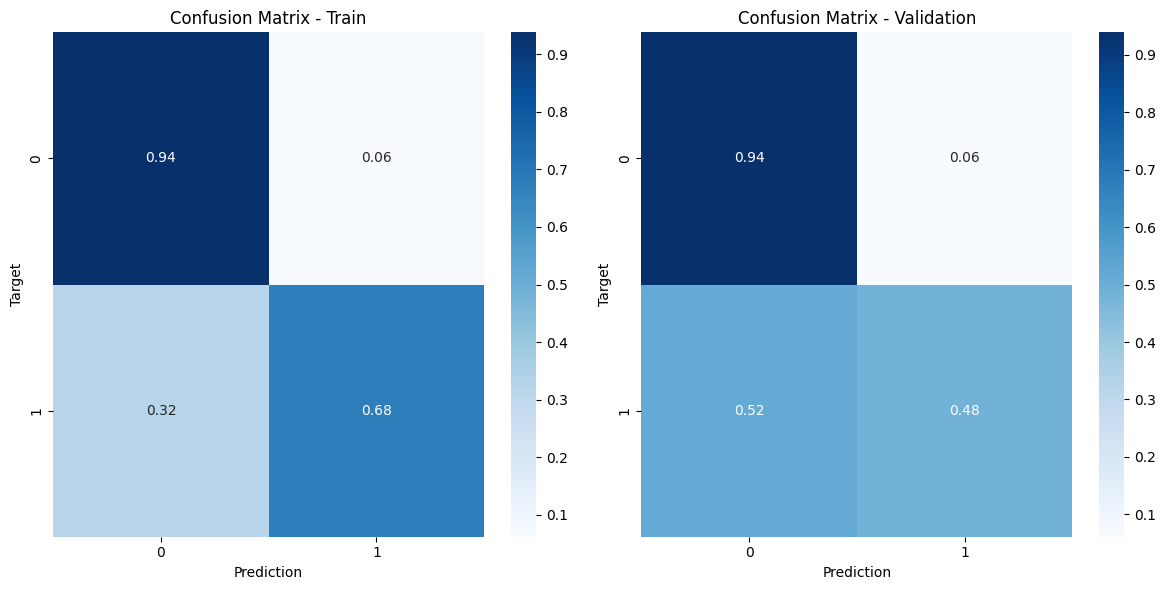

AUROC for Train dataset: 0.9078
AUROC for Validation dataset: 0.7958


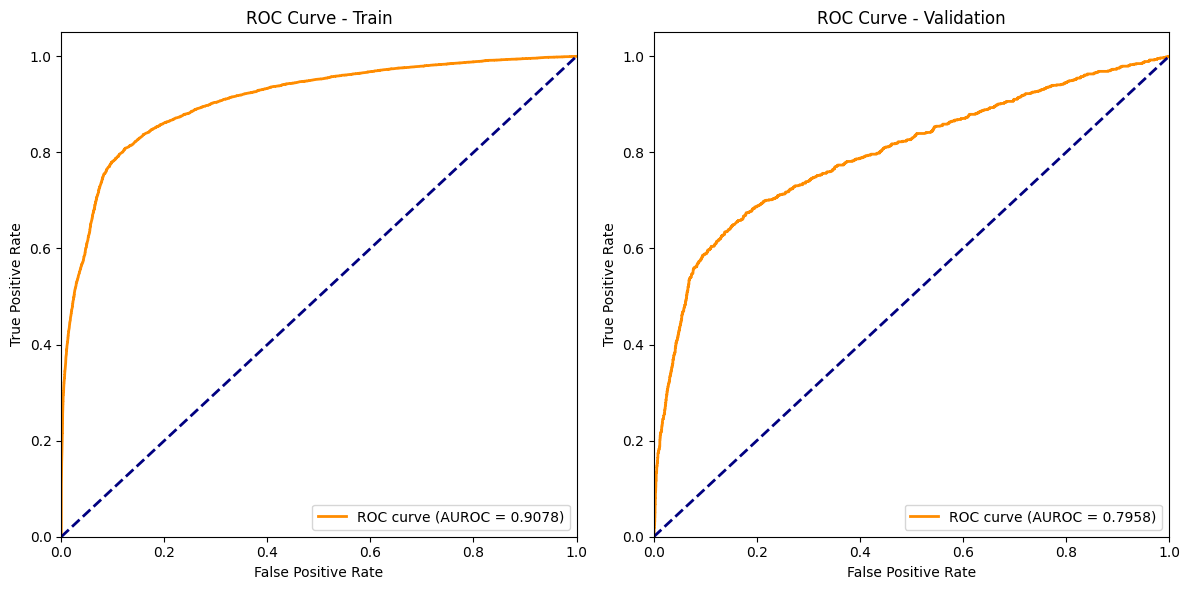

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7503 │           0.4921 │
│ roc_auc  │      0.9078 │           0.7958 │
└──────────┴─────────────┴──────────────────┘

In [126]:
evaluate_model(lgb_model_r_rs, "With RandomizedSearchCV tuning and resampling")

**Спостереження**:

- Модель добре передбачає негативні випадки.
- Бачимо по roc_auc, що модель має перенавчання. Значення на тренувальному наборі достатньо високе, але зменшується на валідації.
- Загалом F1-score трохи покращився у порівнянні з базовим LightGBM.
- F1-score значно падає на тренувальному наборі, що означає проблеми з передбаченнями, на нових даних.

In [127]:
model_comparator.update_model_comment(lgb_model_r_rs, "Хороша модель. Наявне перенавчання, можна спробувати покращити.")

#### LGBMModel with tuning hyperparameters via Hyperopt

In [161]:
lgb_space_h = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 25),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.5),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.05)
}

In [162]:
tuner_hyperopt_lgb = HyperoptTuner(LGBMClassifier, X_train, y_train, X_val, y_val, lgb_space_h)
best_params_hyperopt_lgb = tuner_hyperopt_lgb.tune(transform=False)

 35%|███▌      | 7/20 [00:06<00:11,  1.10trial/s, best loss: -0.8180952668757961]


In [163]:
lgb_model_h = LGBMModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
                        params=best_params_hyperopt_lgb).fit().predict()

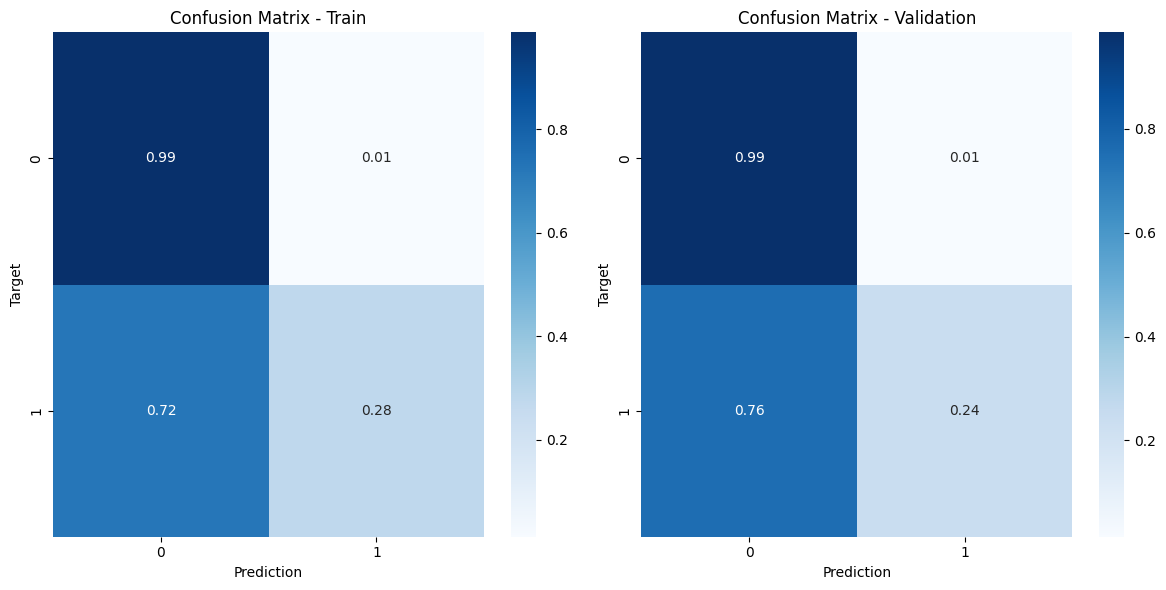

AUROC for Train dataset: 0.8387
AUROC for Validation dataset: 0.8187


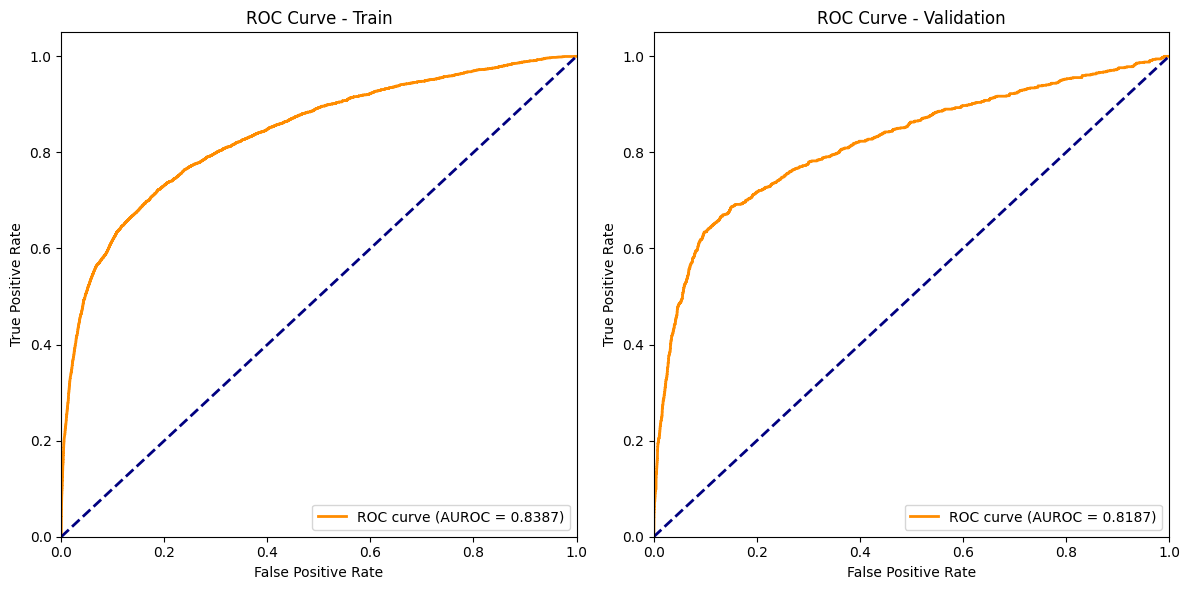

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.4038 │           0.3582 │
│ roc_auc  │      0.8387 │           0.8187 │
└──────────┴─────────────┴──────────────────┘

In [131]:
evaluate_model(lgb_model_h, "With Hyperopt tuning")

**Спостереження**:

- Модель добре передбачає негативні випадки: 98% реальних "Ні" правильно передбачено як "Ні".
- Лише 1.7% (та 1.3% на тренуванні) помилково передбачено укладання депозиту для тих, хто не уклав.
- 68.7% (на тренуванні) та 72.9% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зі значень метрики AUROC бачимо, що є невеликий розрив між тренувальним та вваліджаційним наборами даних.
- F1-score покращився у порівнянні з RandomizedSearchCV, але незначно.
- Hyperopt дозволив досягти трохи кращої продуктивності без значного перенавчання.
- Модель добре розрізняє класи, але все ще має труднощі з точним передбаченням класу "Так".


In [132]:
model_comparator.update_model_comment(lgb_model_h,
                                      "Хороша модель. Hyperopt покращив AUROC та трохи підвищив F1-score. Все ще є проблеми з розпізнаванням позитивного класу.")

#### LGBMModel with tuning hyperparameters via Hyperopt and resampling


In [133]:
lgb_model_h_rs = LGBMModel(X_train=X_t_resampled_smotenc, y_train=y_t_resampled_smotenc, X_val=X_val, y_val=y_val, params=best_params_hyperopt_lgb).fit().predict()

[LightGBM] [Info] Number of positive: 14619, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 43857, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


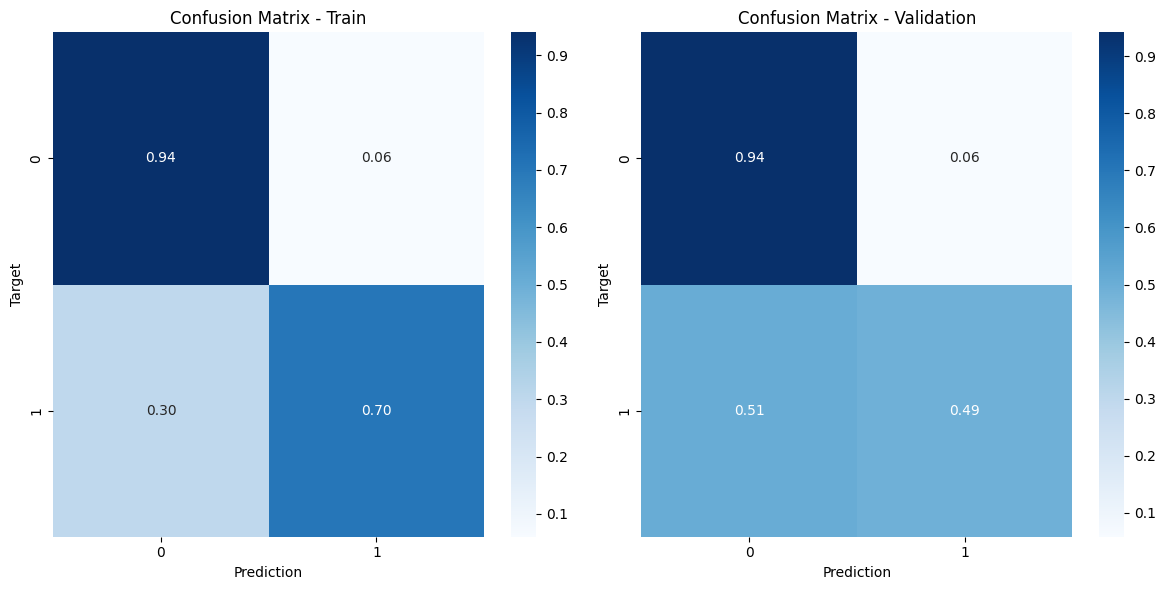

AUROC for Train dataset: 0.9241
AUROC for Validation dataset: 0.8023


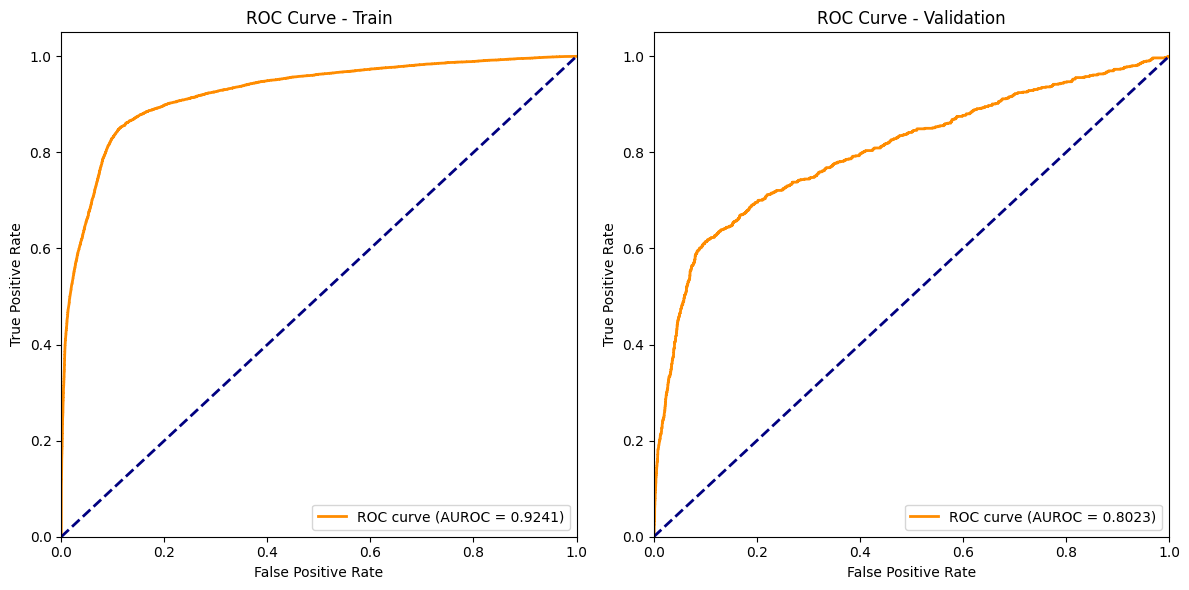

          Model Evaluation Metrics           
┏━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ Train Value ┃ Validation Value ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ f1_score │      0.7709 │           0.5047 │
│ roc_auc  │      0.9241 │           0.8023 │
└──────────┴─────────────┴──────────────────┘

In [134]:
evaluate_model(lgb_model_h_rs, "With Hyperopt tuning and resampling")

**Спостереження**:

- Модель добре передбачає негативні випадки: 94% реальних "Ні" правильно передбачено як "Ні".
- 6% помилково передбачено укладання депозиту для тих, хто не уклав.
- 30% (на тренуванні) та 53% (на валідації) передбачено як "Ні", коли насправді "Так".
- Зі значень метрики AUROC бачимо, що є розрив між тренувальним та валіджаційним наборами даних, отже наявне перенавчання.
- Модель добре розрізняє класи, але все ще має труднощі з точним передбаченням класу "Так".

In [135]:
model_comparator.update_model_comment(lgb_model_h_rs, "Хороша модель. Наявне перенавчання, можна спробувати покращити якість моделі.")

## Аналіз моделей

Отже, натренувавши 24 моделі, можемо бачити, що для більшості моделей притаманне перенавчання, та відносно не високі значення F1_score.
Було проведено експерименти на даних з оверсамплінгом та без ресамплінгу. Підсумовуючи можемо сказати, що балансування вибиріки приводлило до покращення значень метрик, як на тренувальному так і на валідаційному наборах. Але дуже часто спостерігалось перенавчання при застосуванні ресамплінгу.

Основні аспекти, які розглядались при оцінці моделей:

- Якість класифікації (F1-score, AUROC):
    - Для оцінки кожної окремої моделі та формування коментаря до неї враховувалось значення F1-score, оскільки він показує баланс між precision (точністю) і recall (повнотою) для позитивного класу.
    - AUROC використано як загальний індикатор якості моделювання- дана метрика обрана як основна.

- Стійкість моделі до перенавчання:

    - Проаналізовано різницю між результатами на тренувальній (Train) та валідаційній (Validation) вибірках.
    - Для багатьох моделей спостерігається перенавчання, особливо при застосуванні оверсамплінгу.

- Вплив тюнингу та балансування класів:

    - Використання поліноміальних ознак трохи покращувало точність, але мало незначний вплив на загальну якість.
    - Ресемплінг суттєво покращував здатність розпізнавання позитивного класу, але часто приводив до перенавчання.
    - Тюнінг гіперпараметрів (RandomizedSearchCV, Hyperopt) у більшості випадків покращував узагальнюючу здатність моделі.

Подивимось на задагільні результати проведених експериментів

In [136]:
model_comparator.compare_models().head(25)

,Model,Hyperparameters,roc_auc_T,roc_auc_V,Notes,Comment
0,LogisticRegressionModel,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.7864,0.7993,Baseline model.,"Посередня модель. Слабкий recall для класу 1, ..."
1,LogisticRegressionModel,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.8163,0.7964,Added polynomial features.,Посередня модель. Поліноміальні ознаки незначн...
2,LogisticRegressionModel,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.8648,0.7898,With data resampling.,Посередня модель. Ресемплінг значно покращив T...
3,KNNModel,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.9510,0.7098,kNN k=3,"Посередня модель. Високий AUC (0.95) на train,..."
4,KNNModel,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.9245,0.7332,kNN k=5,Посередня модель. AUC впав з 0.92 (train) до 0...
5,KNNModel,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.8877,0.7550,kNN k=10,"Посередня модель. Менше перенавчання, але слаб..."
6,KNNModel,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.9800,0.7058,kNN k=3 with resampling,Перенавчена модель. Ресемплінг покращив TPR дл...
7,KNNModel,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.9661,0.7273,kNN k=5 with resampling,Перенавчена модель. Ресемплінг покращив TPR дл...
8,KNNModel,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.9414,0.7421,kNN k=10 with resampling,Посередня модель. Найкраще значення AUC серед ...
9,DecisionTreeModel,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.7854,0.7955,Baseline model,"Посередня модель. Стабільна, без перенавчання,..."


**Спостереження**:

Найкраще себе показала модель XGBModel з тюнингом гіперпараметрів за допомогою RandomizedSearchCV


## Аналіз ознак XGBModel

In [137]:
xgb_model_r

feature_importance = xgb_model_r.model.feature_importances_
features = X_train.columns
df_importance = pd.DataFrame({"Feature": features, "Importance": feature_importance})
df_importance = df_importance.sort_values(by="Importance", ascending=False)
df_importance

,Feature,Importance
11,nr.employed,0.563544
18,was_contacted_before,0.062751
47,poutcome_success,0.050366
7,emp.var.rate,0.049365
3,month,0.033297
10,euribor3m,0.014479
2,contact,0.013067
15,default_unknown,0.012712
9,cons.conf.idx,0.012563
8,cons.price.idx,0.012015


## Аналіз ознак LGBMModel

Проглянемо найважливіші ознаки для моделі

In [138]:
# feature_importance = lgb_model_r_rs.model.feature_importances_
# features = X_train.columns
# df_importance = pd.DataFrame({"Feature": features, "Importance": feature_importance})
# df_importance = df_importance.sort_values(by="Importance", ascending=False)
# df_importance

**Спостереження**:

1. Макроекономічні показники мають найбільший вплив

- euribor3m, cons.conf.idx, cons.price.idx, emp.var.rate, nr.employed.
- Висока важливість цих змінних свідчить про те, що загальний економічний стан країни впливає на ймовірність укладення депозиту.
- Euribor3m є найвпливовішою ознакою, що цілком логічно, адже процентні ставки безпосередньо впливають на фінансові рішення клієнтів.
- Індекс споживчих цін та довіри (cons.conf.idx, cons.price.idx) також відіграють суттєву роль, адже відображають загальний рівень оптимізму або песимізму споживачів.

2. Демографічні характеристики

- age – досить важлива змінна, адже фінансові звички змінюються з віком. Молодші люди можуть бути менш схильні до відкриття строкових депозитів.
- Освіта – наявність освіти впливає на прийняття фінансових рішень, але не є критично важливим фактором.

    Job:

- Найбільш важливі: "blue-collar", "admin.", "technician" – тобто професії середнього класу.
- Менший вплив мають "housemaid", "student", "retired" – ці групи менш активно беруть участь у фінансових операціях.
- "unknown" – мала важливість, що вказує на слабкий вплив категорії "невідомо".

3. Контактна інформація та взаємодія з клієнтами
- total_contacts, campaign, campaign_previous_ratio, contact, previous
- Кількість контактів (total_contacts, campaign) має суттєвий вплив: чим більше клієнта контактують, тим більша ймовірність, що він підпише депозит.
- campaign_previous_ratio – співвідношення кампанії до попередніх контактів теж є значущим, що вказує на важливість правильної взаємодії з клієнтом.
- contact – тип контакту (телефон чи інший) впливає на рішення клієнта.

4. Часові характеристики

- month, day_of_week, second_half_year , weekday_call
- Місяць контакту (month) – має відчутний вплив, що може вказувати на сезонність у фінансових рішеннях.
- День тижня контакту (day_of_week) також є відносно важливим.
- weekday_call – ця ознака виявилася неважливою, тобто день тижня не впливає на рішення клієнтів.

5. Фінансові характеристики клієнта

- loan_yes, housing_yes, default_no, default_unknown
- Клієнти з кредитами менш схильні до укладення депозиту, оскільки мають інші фінансові зобов’язання.
- Клієнти без кредиту – менш впливова категорія.
- Наявність житлового кредиту – майже не впливає на результат.
- default_yes – ознака неважлива, тобто клієнти, що мали історію дефолту, не впливають суттєво на рішення про депозит.

6. Попередні кампанії та їх результати

- poutcome_failure, poutcome_success, poutcome_nonexistent
- Якщо клієнт вже брав участь у попередніх кампаніях і його результат був "успішним", він частіше підписує депозит.
- poutcome_failure має вищу вагу, ніж poutcome_success, що може означати, що клієнти, які не змогли укласти договір раніше, все ще мають високий шанс підписати його зараз.
- poutcome_nonexistent – майже не впливає, тобто нові клієнти не відрізняються від інших за рівнем ймовірності укладання депозиту.

7. Невпливові ознаки
- marital_status – сімейний статус майже не впливає на результат.
- education_unknown, marital_unknown, housing_unknown, loan_unknown – ознаки з відсутньою інформацією не несуть корисної предиктивної вартості.
- was_previously_contacted – несподівано не має значного впливу.


Загалом показники логічні, модель сильно залежить від економічних показників та частоти взаємодії з клієнтом. Це підтверджує, що контактна стратегія та економічна ситуація є ключовими факторами успіху кампанії.

Підсумрвуючи маємо:

Макроекономічні фактори – ключові драйвери:
- Euribor3m – найважливіша ознака. Логічно, що рівень процентних ставок впливає на рішення клієнтів щодо депозитів.
- conf.idx, cons.price.idx, emp.var.rate, nr.employed – макроекономічні показники справді впливають на поведінку клієнтів: Якщо індекс довіри споживачів низький, люди менше вкладають гроші.Якщо рівень безробіття високий, потенційні вкладники менш охоче роблять депозити.

Контактна інформація впливає, але без перебільшень
- tal_contacts , campaign, campaign_previous_ratio, contact – підтверджує, що кількість контактів впливає, але є межа ефективності.
- previous – несподівано низька важливість, адже попередні контакти повинні б мати більший вплив.

Демографічні показники менш важливі:
- Вік – важливий, але не критично. Це має сенс: молодші люди рідше відкривають депозити, але цей ефект не такий суттєвий, як економічні фактори.
- Освіта та професія впливають, що узгоджується з фінансовою грамотністю та доходами клієнтів.
- Сімейний статус – очікувано неважливий, адже рішення про депозит не залежить напряму від шлюбу чи його відсутності.

Часові фактори показують сезонність
- month, day_of_week – логічно, що є сезонний вплив, наприклад, більше депозитів оформлюють у певні місяці.
- weekday_call – цілком очікувано, що день тижня не має значення для прийняття фінансових рішень.

## Експерименти з найкращою моделлю

In [139]:
num_runs = 10
feature_importances = np.zeros((num_runs, X_train.shape[1]))
start_time = time.time()

for i in range(num_runs):
    best_params = tuner_random_xgb.tune()
    xgb_model = XGBModel(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, params=best_params).fit()
    feature_importances[i, :] = xgb_model.model.feature_importances_
mean_importance = np.mean(feature_importances, axis=0)
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Mean Importance": mean_importance})
importance_df = importance_df.sort_values(by="Mean Importance", ascending=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

KeyboardInterrupt: 

In [ ]:
feature_importances

In [ ]:
print(importance_df)

## Аналіз ознак з бібліотекою SHAP

## Аналіз помилок

In [ ]:
analyzer = ModelErrorAnalyzer(model=xgb_model_r, X_val=X_val, y_val=y_val)

In [ ]:
fp, fn = analyzer.get_misclassified_samples()
display(fp.head(5)), display(fn.head(5))

In [ ]:
analyzer.visualize_misclassified_samples()

In [ ]:
analyzer.analyze_top_features(top_n=10)